Performed for a run where the original graphs were run for 100 batchs

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os
import re
from os.path import join as pj

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sae_lens import SAE, ActivationsStore
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from transformer_lens import HookedTransformer

from sae_cooccurrence.graph_generation import (
    load_subgraph,
    plot_subgraph_static,
)
from sae_cooccurrence.normalised_cooc_functions import (
    get_sae_release,
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    analyze_representative_points,
    analyze_specific_points,
    calculate_pca_decoder,
    create_pca_plots_decoder,
    generate_data,
    load_data_from_pickle,
    plot_doubly_clustered_activation_heatmap,
    plot_pca_explanation_and_save,
    plot_pca_feature_strength,
    plot_pca_with_active_features,
    plot_pca_with_top_feature,
    plot_simple_scatter,
    plot_token_pca_and_save,
    save_data_to_pickle,
)
from sae_cooccurrence.utils.saving_loading import load_npz_files, set_device
from sae_cooccurrence.utils.set_paths import get_git_root

# Set up logging and paths


In [2]:
def setup_logging(log_path):
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )


# Config -------------
torch.set_grad_enabled(False)
device = set_device()
git_root = get_git_root()

Using MPS


# Settings to perform PCA on a particular subgraph

In [3]:
save_figs = True

# model_name = "gpt2-small"
# sae_release_short = "res-jb-feature-splitting"
# sae_id = "blocks.8.hook_resid_pre_24576"
# n_batches_reconstruction = 25

model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_12/width_16k/canonical"
n_batches_reconstruction = 100
remove_special_tokens = True

activation_threshold = 1.5
subgraph_id = 2282

In [4]:
np.random.seed(1234)

fs_splitting_cluster = subgraph_id
pca_prefix = "pca"

# Load model
model = HookedTransformer.from_pretrained(model_name, device=device)

# Process the specific subgraph
sae_id_neat = neat_sae_id(sae_id)
results_dir = f"results/{model_name}/{sae_release_short}/{sae_id_neat}"
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)
pickle_file = pj(pca_path, f"pca_data_subgraph_{subgraph_id}.pkl")

# Set up logging
log_path = pj(pca_path, "pca_analysis.log")
setup_logging(log_path)

# Log all settings
logging.info("Script started")
logging.info("Settings:")
logging.info(f"  save_figs: {save_figs}")
logging.info(f"  git_root: {git_root}")
logging.info(f"  sae_id: {sae_id}")
logging.info(f"  activation_threshold: {activation_threshold}")
logging.info(f"  subgraph_id: {subgraph_id}")
logging.info(f"  fs_splitting_cluster: {fs_splitting_cluster}")
logging.info(f"  pca_prefix: {pca_prefix}")
logging.info(f"  model_name: {model_name}")
logging.info(f"  sae_release_short: {sae_release_short}")
logging.info(f"  n_batches_reconstruction: {n_batches_reconstruction}")
logging.info(f"  device: {device}")
logging.info(f"  results_path: {results_path}")
logging.info(f"  pca_path: {pca_path}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [5]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
regen_data = False
if not regen_data:
    raise ValueError("Are you sure you don't want to use existing data?")

ValueError: Are you sure you don't want to use existing data?

In [20]:
if not regen_data and os.path.exists(pickle_file):
    data = load_data_from_pickle(pickle_file)
    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]
else:
    sae_release = get_sae_release(model_name, sae_release_short)

    # Load SAE and set up activation store
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release=sae_release, sae_id=sae_id, device=device
    )
    sae.fold_W_dec_norm()

    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        streaming=True,
        store_batch_size_prompts=8,
        train_batch_size_tokens=4096,
        n_batches_in_buffer=32,
        device=device,
    )

    data = generate_data(
        model,
        sae,
        activation_store,
        fs_splitting_nodes,
        n_batches_reconstruction,
        decoder=False,
        remove_special_tokens=remove_special_tokens,
        device=device,
    )

    if regen_data:
        save_data_to_pickle(data, pickle_file)

    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]

In [19]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

if pca_decoder is not None:
    pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)
    # Save pca_decoder_df as CSV
    pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
    pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

    create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

Processing completed for subgraph ID 2282


In [11]:
plot_pca_with_top_feature(
    pca_df, results, fs_splitting_nodes, fs_splitting_cluster, pca_path, save=save_figs
)

In [18]:
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC2",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC3",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

In [11]:
plot_pca_with_active_features(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    activation_threshold=activation_threshold,
    save=save_figs,
)

In [12]:
plot_doubly_clustered_activation_heatmap(
    results,
    fs_splitting_nodes,
    pca_df,
    pca_path,
    fs_splitting_cluster,
    max_examples=1000,
    save=save_figs,
)

In [19]:
analyze_representative_points(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing representative point 1:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 39
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.3027
Mean activation of non-zero non-feature splitting nodes: 3.2734
Median activation of non-zero feature splitting nodes: 0.3027
Median activation of non-zero non-feature splitting nodes: 1.1038
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 15
Sum of activation strengths for splitting features: 0.3027
Sum of activation strengths for non-splitting features: 124.3899

Analyzing representative point 2:


Number of non-zero features: 23
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 0.4615
Mean activation of non-zero non-feature splitting nodes: 4.6290
Median activation of non-zero feature splitting nodes: 0.4615
Median activation of non-zero non-feature splitting nodes: 1.4941
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 11
Sum of activation strengths for splitting features: 0.4615
Sum of activation strengths for non-splitting features: 101.8379

Analyzing representative point 3:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 4:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.2277
Mean activation of non-zero non-feature splitting nodes: 2.9216
Median activation of non-zero feature splitting nodes: 1.2277
Median activation of non-zero non-feature splitting nodes: 1.2821
Number of splitting features active above threshold: 0
Number of non-splitting features active above threshold: 26
Sum of activation strengths for splitting features: 1.2277
Sum of activation strengths for non-splitting features: 157.7681

Analyzing representative point 5:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:624: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:625: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:626: UserWarning:

Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_c

Number of non-zero features: 44
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 1.6251
Mean activation of non-zero non-feature splitting nodes: 3.3963
Median activation of non-zero feature splitting nodes: 1.6251
Median activation of non-zero non-feature splitting nodes: 1.1159
Number of splitting features active above threshold: 1
Number of non-splitting features active above threshold: 19
Sum of activation strengths for splitting features: 1.6251
Sum of activation strengths for non-splitting features: 146.0398


In [23]:
# After creating the PCA plot and identifying interesting points
interesting_point_ids = [0]  # Replace with actual IDs of interest
analyze_specific_points(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,
    interesting_point_ids,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 0:


/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [35]:
plot_subgraph_static(
    subgraph=load_subgraph(results_path, activation_threshold, subgraph_id),
    node_info_df=node_df,
    output_path=os.path.join(pca_path, "overall_subgraph"),
    activation_array=overall_feature_activations,
    normalize_globally=False,
    save_figs=True,
)

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/graph_generation.py:621: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [23]:
def plot_pca_preceding_words(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Vectorize the context cleaning operation
    # Clean LaTeX and special characters
    def clean_text(text):
        # Remove LaTeX math mode content
        text = re.sub(r"\$.*?\$", "", text)
        # # Remove other special characters as needed
        # text = re.sub(r'[^\w\s]', '', text)
        return text.strip()

    pca_df["cleaned_context"] = (
        pca_df["context"].str.replace("<|endoftext|>", "").apply(clean_text)
    )

    # More efficient preceding word extraction using pandas operations
    def extract_preceding_word_vectorized(row):
        try:
            parts = row["cleaned_context"].split(f"|{row['tokens']}|")
            if len(parts) < 2:
                return None
            words = parts[0].strip().split()
            return words[-1] if words else None
        except Exception:
            return None

    # Apply the function more efficiently
    pca_df["preceding_word"] = pca_df.apply(extract_preceding_word_vectorized, axis=1)

    # Filter once and create a view
    pca_df_filtered = pca_df.dropna(subset=["preceding_word"])

    # Optional: limit to top N most common preceding words
    top_n = 100  # adjust this number as needed
    top_words = pca_df_filtered["preceding_word"].value_counts().nlargest(top_n).index
    pca_df_filtered = pca_df_filtered[pca_df_filtered["preceding_word"].isin(top_words)]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Use seaborn's scatterplot for automatic color handling
    sns.scatterplot(
        data=pca_df_filtered,
        x="PC2",
        y="PC3",
        hue="preceding_word",
        alpha=0.6,
        s=50,  # marker size
    )

    plt.title(f"PCA Analysis - Cluster {fs_splitting_cluster} (By Preceding Word)")
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    # Adjust legend with smaller font
    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="small"
    )

    # Use bbox_inches='tight' in tight_layout to handle legend
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_preceding_words_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_13318/4074480086.py:60: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



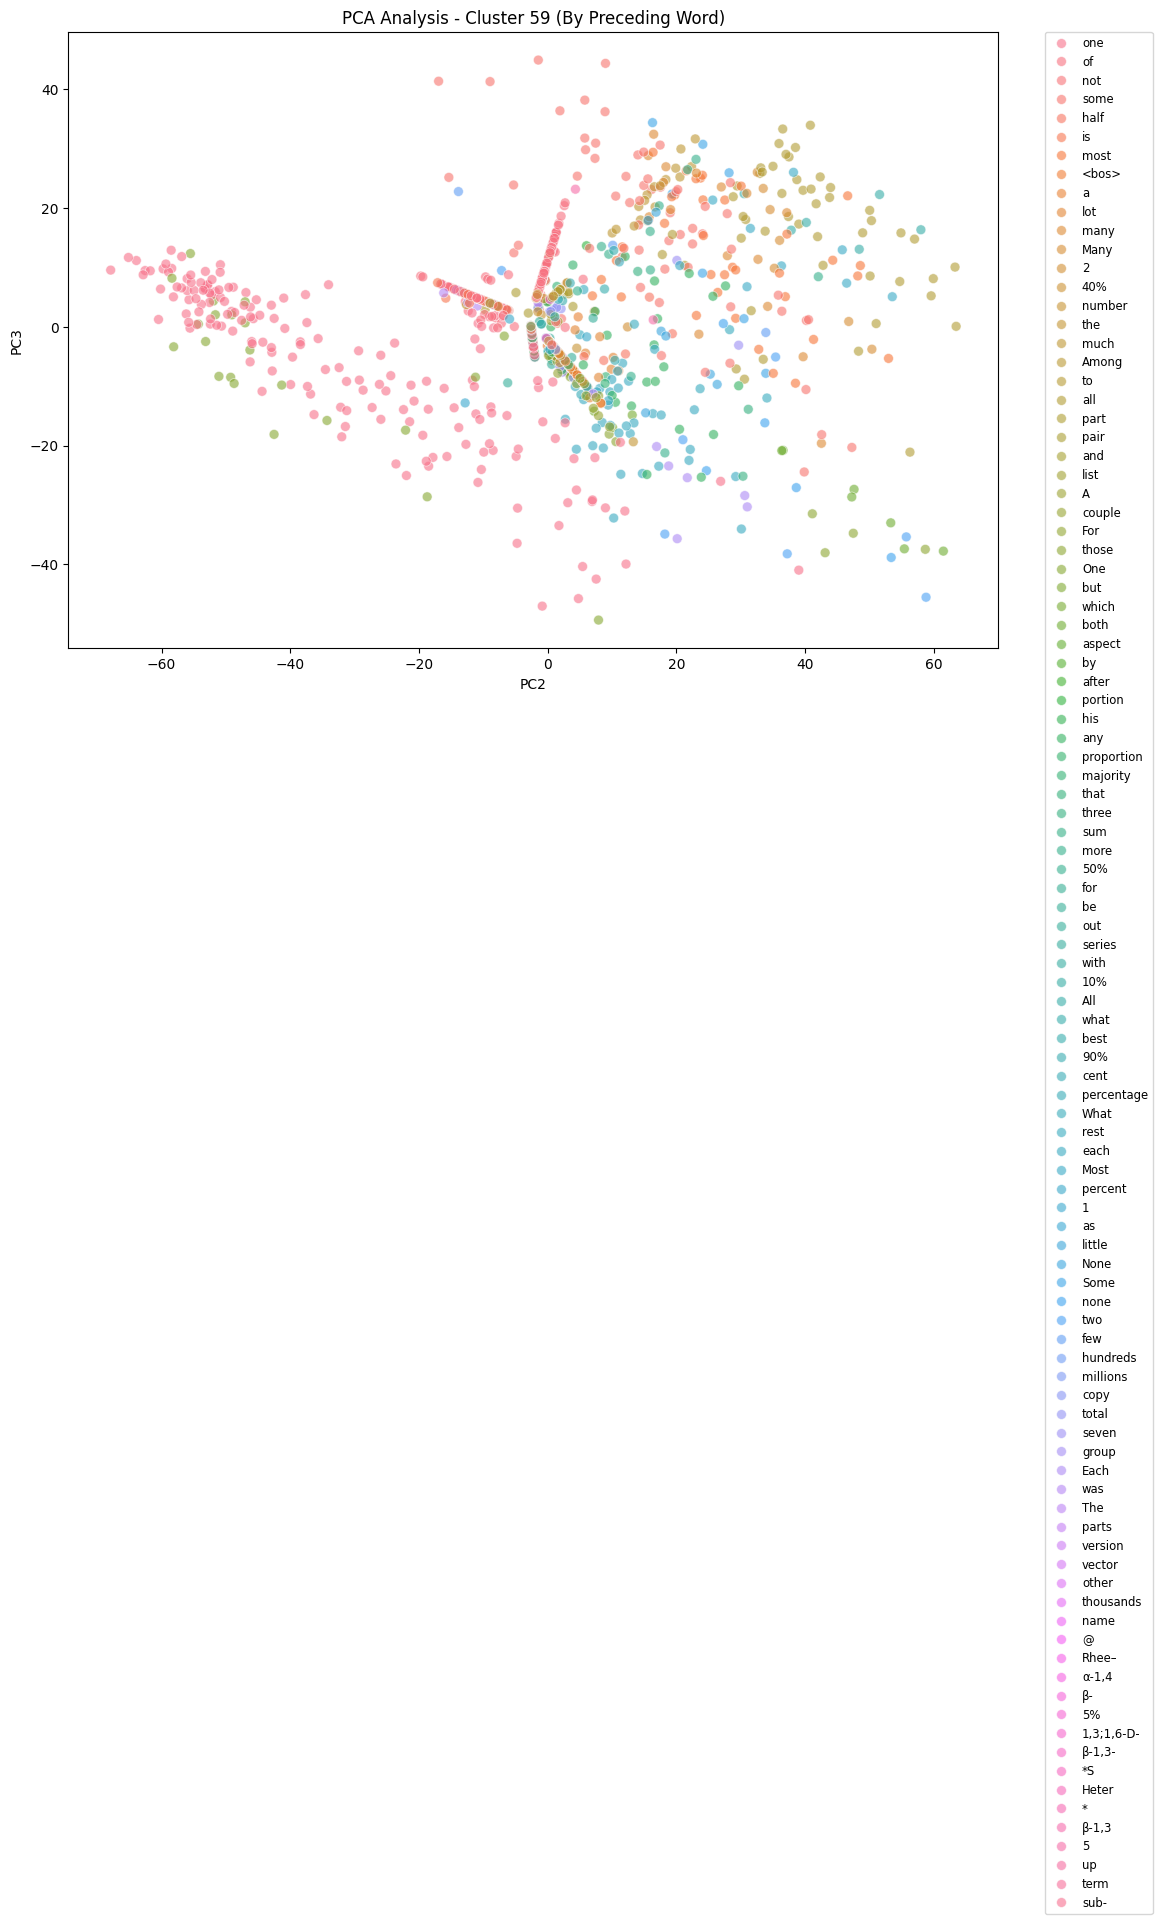

In [24]:
plot_pca_preceding_words(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [26]:
def plot_pca_years(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Function to extract year from context
    def extract_year(context):
        # Look for 4-digit numbers that could be years
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            # If multiple years found, take the closest one to the token
            # (for now, just taking the first one found)
            return int(years[0])
        return None

    # Clean context and extract years
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["year"] = pca_df["cleaned_context"].apply(extract_year)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot non-year points first (grey and translucent)
    non_year_mask = pca_df["year"].isna()
    plt.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year in context",
    )

    # Plot year points with a colormap
    year_mask = ~non_year_mask
    if year_mask.any():
        scatter = plt.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter, label="Year in Context")

    plt.title(
        f"PCA Analysis - Cluster {fs_splitting_cluster} (Colored by Year in Context)"
    )
    plt.xlabel("PC2")
    plt.ylabel("PC3")

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_years_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

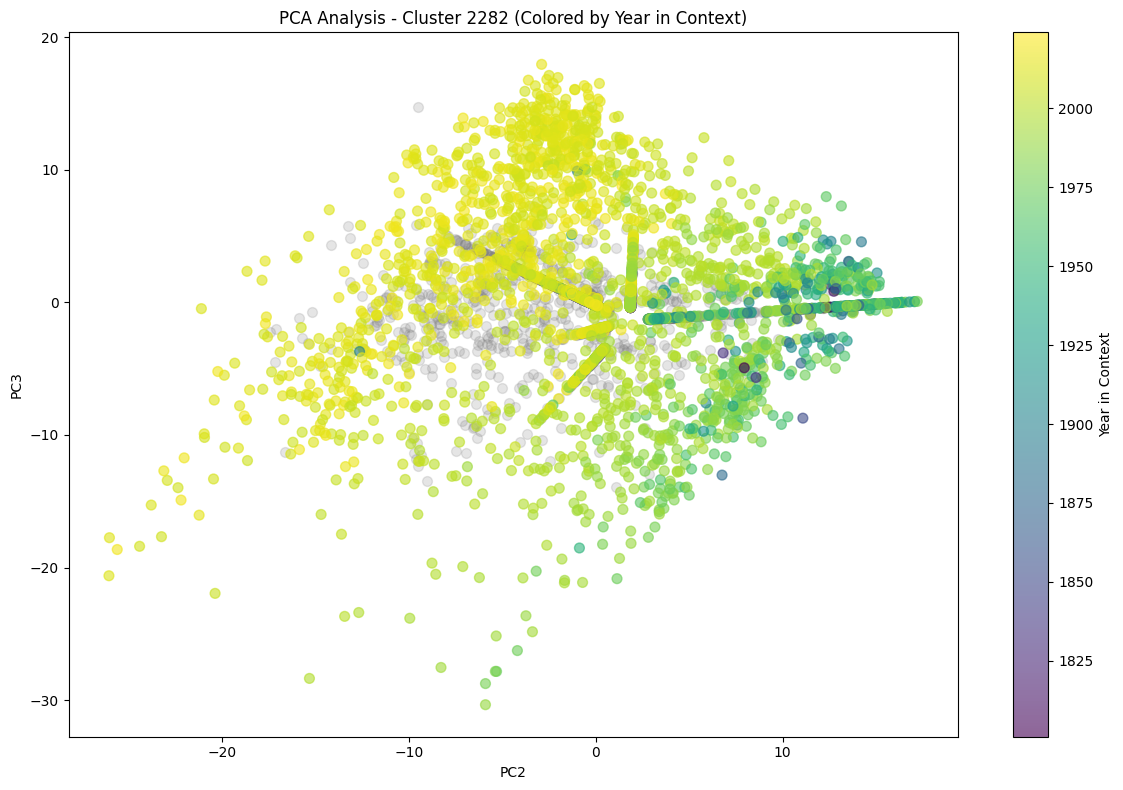

In [27]:
plot_pca_years(pca_df, pca_path, fs_splitting_cluster, save_figs)

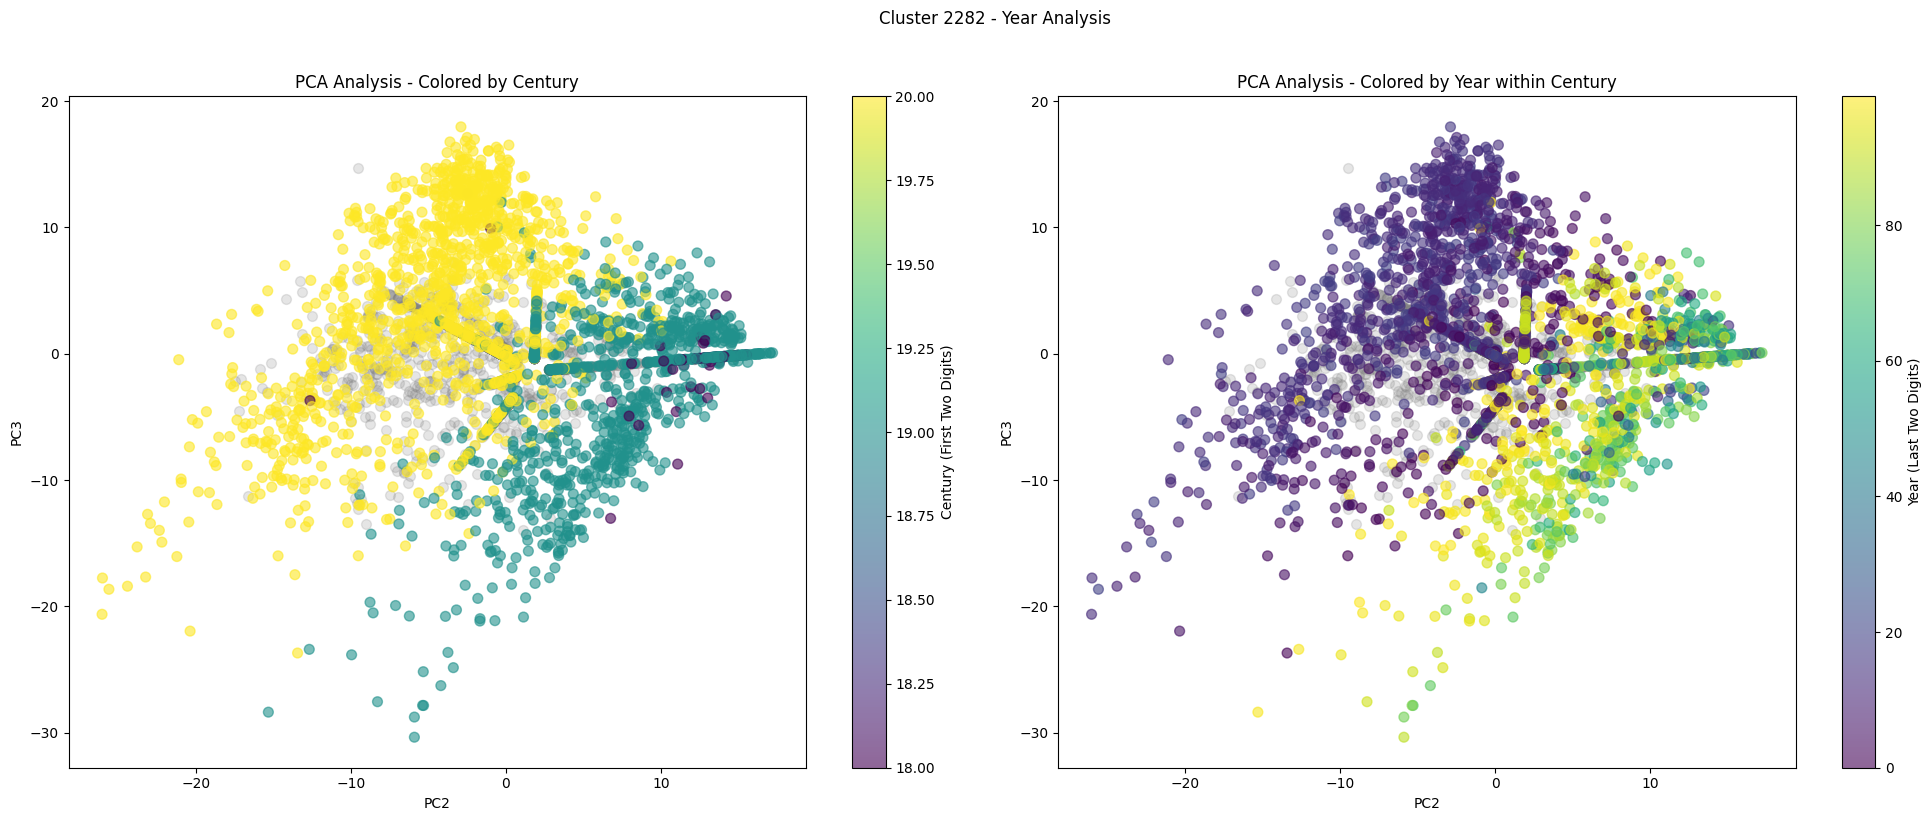

In [28]:
def plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Function to extract year and its parts from context
    def extract_year_parts(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = int(years[0])
            return {
                "year": year,
                "century_part": year // 100,  # First two digits
                "year_part": year % 100,  # Last two digits
            }
        return None

    # Clean context and extract year parts
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    year_parts = pca_df["cleaned_context"].apply(extract_year_parts)

    # Convert year parts to separate columns
    pca_df["century_part"] = year_parts.apply(
        lambda x: x["century_part"] if x else None
    )
    pca_df["year_part"] = year_parts.apply(lambda x: x["year_part"] if x else None)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: First two digits (century)
    non_year_mask = pca_df["century_part"].isna()
    ax1.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    year_mask = ~non_year_mask
    if year_mask.any():
        scatter1 = ax1.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "century_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=ax1, label="Century (First Two Digits)")

    ax1.set_title("PCA Analysis - Colored by Century")
    ax1.set_xlabel("PC2")
    ax1.set_ylabel("PC3")

    # Plot 2: Last two digits
    ax2.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter2 = ax2.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=ax2, label="Year (Last Two Digits)")

    ax2.set_title("PCA Analysis - Colored by Year within Century")
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

    plt.suptitle(f"Cluster {fs_splitting_cluster} - Year Analysis", y=1.02)
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_year_parts_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs)

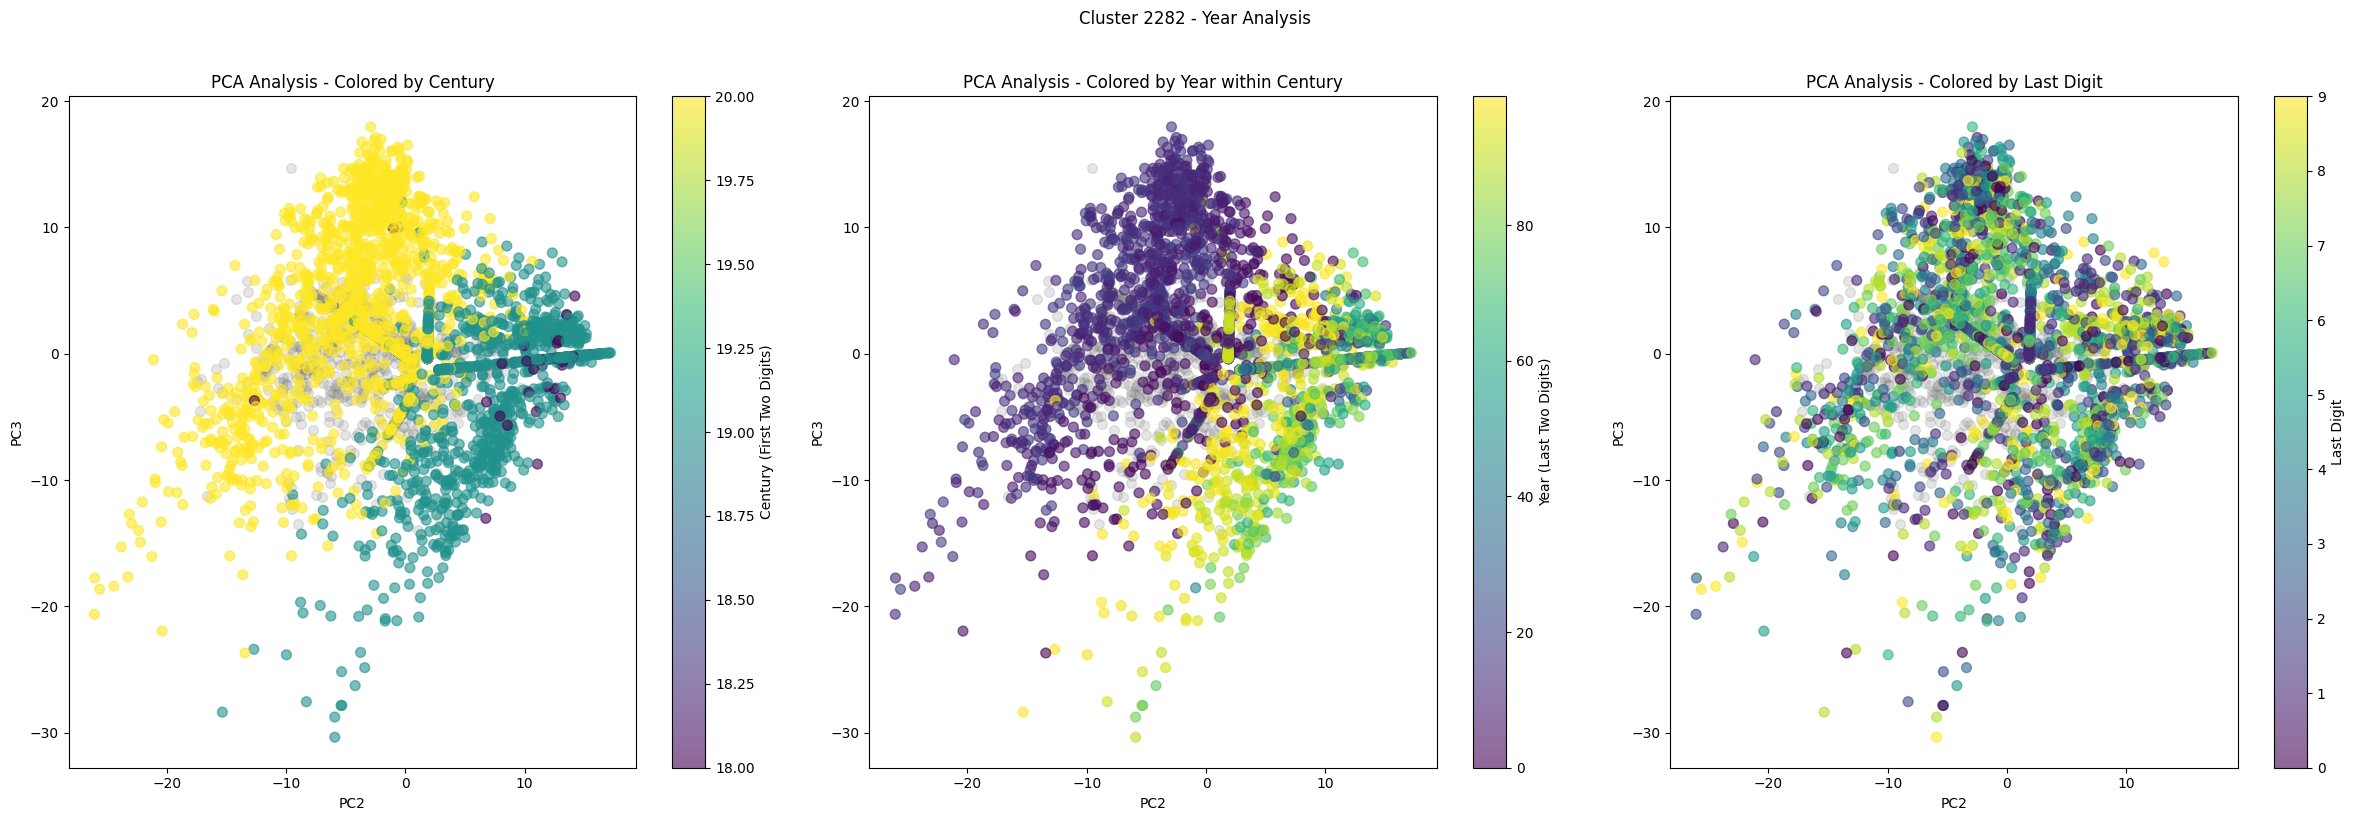

In [30]:
def plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Function to extract year and its parts from context
    def extract_year_parts(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = int(years[0])
            return {
                "year": year,
                "century_part": year // 100,  # First two digits
                "year_part": year % 100,  # Last two digits
                "last_digit": year % 10,  # Last digit
            }
        return None

    # Clean context and extract year parts
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    year_parts = pca_df["cleaned_context"].apply(extract_year_parts)

    # Convert year parts to separate columns
    pca_df["century_part"] = year_parts.apply(
        lambda x: x["century_part"] if x else None
    )
    pca_df["year_part"] = year_parts.apply(lambda x: x["year_part"] if x else None)
    pca_df["last_digit"] = year_parts.apply(lambda x: x["last_digit"] if x else None)

    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: First two digits (century)
    non_year_mask = pca_df["century_part"].isna()
    ax1.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    year_mask = ~non_year_mask
    if year_mask.any():
        scatter1 = ax1.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "century_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=ax1, label="Century (First Two Digits)")

    ax1.set_title("PCA Analysis - Colored by Century")
    ax1.set_xlabel("PC2")
    ax1.set_ylabel("PC3")

    # Plot 2: Last two digits
    ax2.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter2 = ax2.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=ax2, label="Year (Last Two Digits)")

    ax2.set_title("PCA Analysis - Colored by Year within Century")
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")

    # Plot 3: Last digit
    ax3.scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )

    if year_mask.any():
        scatter3 = ax3.scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "last_digit"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter3, ax=ax3, label="Last Digit")

    ax3.set_title("PCA Analysis - Colored by Last Digit")
    ax3.set_xlabel("PC2")
    ax3.set_ylabel("PC3")

    plt.suptitle(f"Cluster {fs_splitting_cluster} - Year Analysis", y=1.02)
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_year_parts_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_year_parts(pca_df, pca_path, fs_splitting_cluster, save_figs)

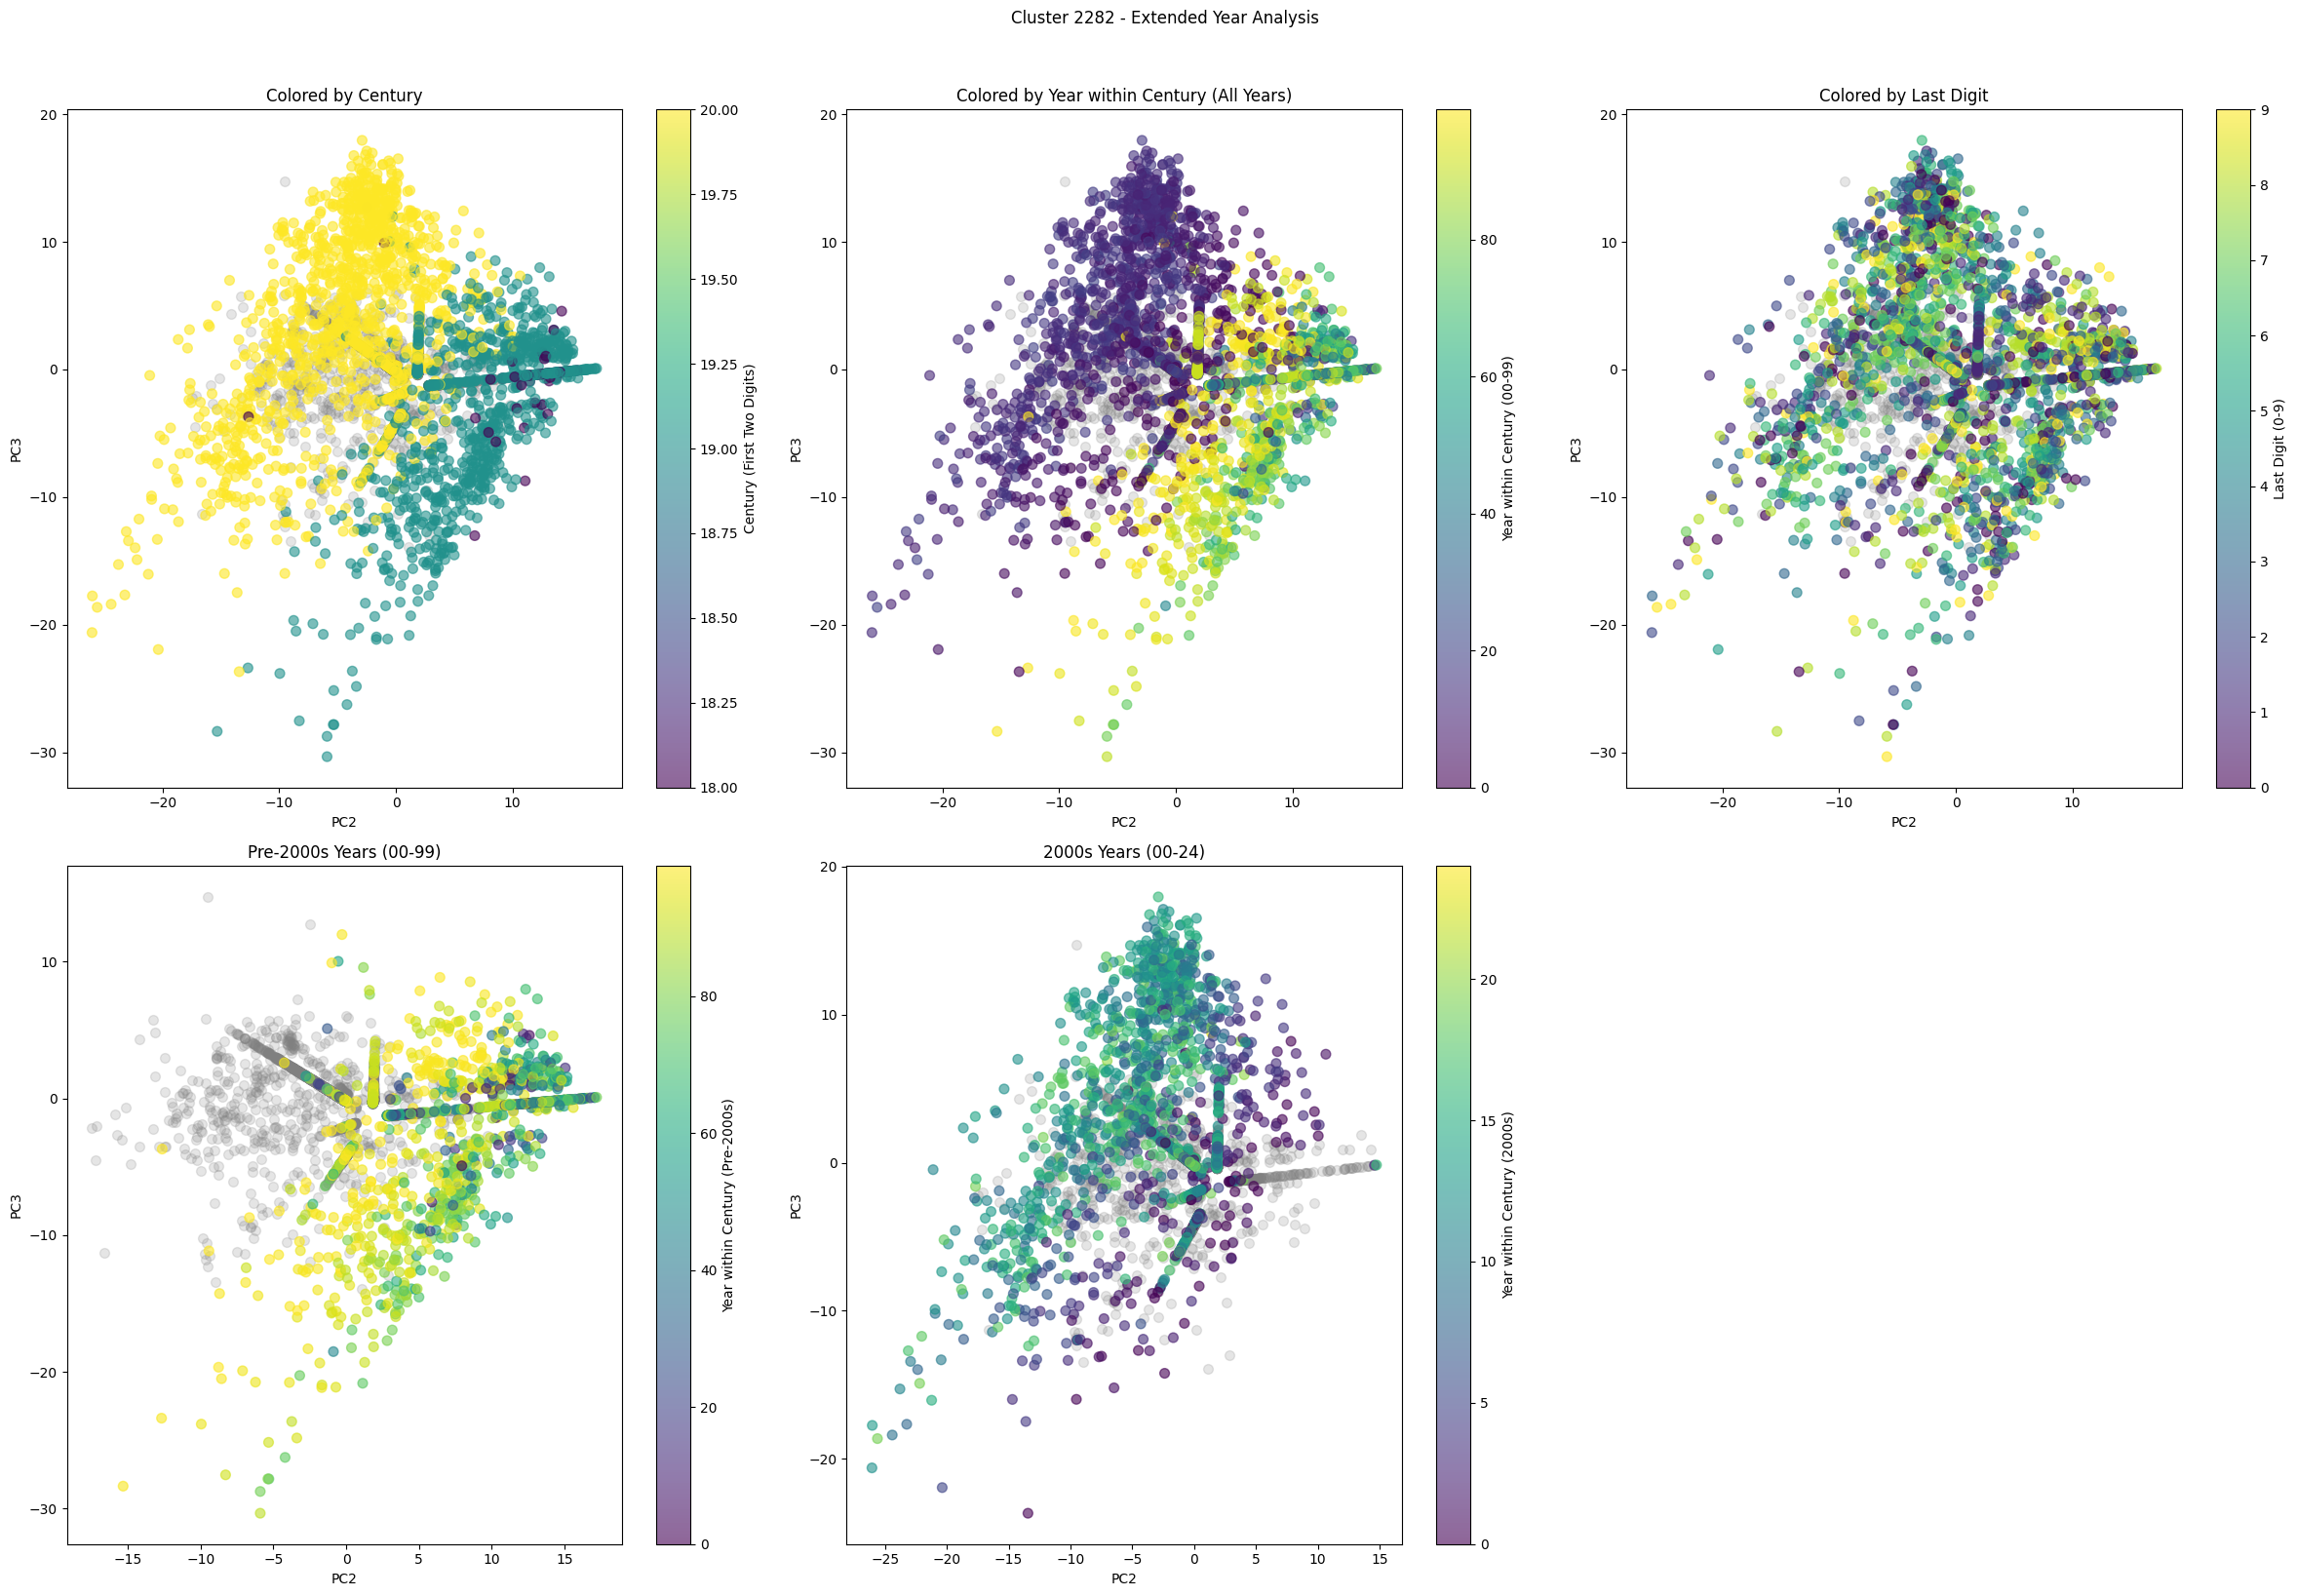

In [31]:
def plot_pca_year_parts_extended(
    pca_df, pca_path, fs_splitting_cluster, save_figs=False
):
    # Function to extract year and its parts from context
    def extract_year_parts(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = int(years[0])
            return {
                "year": year,
                "century_part": year // 100,  # First two digits
                "year_part": year % 100,  # Last two digits
                "last_digit": year % 10,  # Last digit
                "is_2000s": year >= 2000,
            }
        return None

    # Clean context and extract year parts
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    year_parts = pca_df["cleaned_context"].apply(extract_year_parts)

    # Convert year parts to separate columns
    pca_df["century_part"] = year_parts.apply(
        lambda x: x["century_part"] if x else None
    )
    pca_df["year_part"] = year_parts.apply(lambda x: x["year_part"] if x else None)
    pca_df["last_digit"] = year_parts.apply(lambda x: x["last_digit"] if x else None)
    pca_df["is_2000s"] = year_parts.apply(lambda x: x["is_2000s"] if x else None)

    # Create figure with 5 subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    axes = axes.flatten()

    # Original three plots (first row)
    non_year_mask = pca_df["century_part"].isna()
    year_mask = ~non_year_mask

    # Plot 1: Century (First Two Digits)
    axes[0].scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
        label="No year",
    )
    if year_mask.any():
        scatter1 = axes[0].scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "century_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter1, ax=axes[0], label="Century (First Two Digits)")
    axes[0].set_title("Colored by Century")
    axes[0].set_xlabel("PC2")
    axes[0].set_ylabel("PC3")

    # Plot 2: All Years Last Two Digits
    axes[1].scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
    )
    if year_mask.any():
        scatter2 = axes[1].scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter2, ax=axes[1], label="Year within Century (00-99)")
    axes[1].set_title("Colored by Year within Century (All Years)")
    axes[1].set_xlabel("PC2")
    axes[1].set_ylabel("PC3")

    # Plot 3: Last Digit
    axes[2].scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
    )
    if year_mask.any():
        scatter3 = axes[2].scatter(
            pca_df.loc[year_mask, "PC2"],
            pca_df.loc[year_mask, "PC3"],
            c=pca_df.loc[year_mask, "last_digit"],
            cmap="viridis",
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter3, ax=axes[2], label="Last Digit (0-9)")
    axes[2].set_title("Colored by Last Digit")
    axes[2].set_xlabel("PC2")
    axes[2].set_ylabel("PC3")

    # Plot 4: Pre-2000s Years (00-99)
    pre_2000s_mask = (pca_df["is_2000s"] is False) & year_mask
    axes[3].scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
    )
    if pre_2000s_mask.any():
        scatter4 = axes[3].scatter(
            pca_df.loc[pre_2000s_mask, "PC2"],
            pca_df.loc[pre_2000s_mask, "PC3"],
            c=pca_df.loc[pre_2000s_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
            vmin=0,
            vmax=99,
        )
        plt.colorbar(scatter4, ax=axes[3], label="Year within Century (Pre-2000s)")
    axes[3].set_title("Pre-2000s Years (00-99)")
    axes[3].set_xlabel("PC2")
    axes[3].set_ylabel("PC3")

    # Plot 5: 2000s Years (00-24)
    post_2000s_mask = (pca_df["is_2000s"] is True) & year_mask
    axes[4].scatter(
        pca_df.loc[non_year_mask, "PC2"],
        pca_df.loc[non_year_mask, "PC3"],
        color="grey",
        alpha=0.2,
        s=50,
    )
    if post_2000s_mask.any():
        scatter5 = axes[4].scatter(
            pca_df.loc[post_2000s_mask, "PC2"],
            pca_df.loc[post_2000s_mask, "PC3"],
            c=pca_df.loc[post_2000s_mask, "year_part"],
            cmap="viridis",
            alpha=0.6,
            s=50,
            vmin=0,
            vmax=24,
        )
        plt.colorbar(scatter5, ax=axes[4], label="Year within Century (2000s)")
    axes[4].set_title("2000s Years (00-24)")
    axes[4].set_xlabel("PC2")
    axes[4].set_ylabel("PC3")

    # Remove the empty subplot
    axes[5].remove()

    plt.suptitle(f"Cluster {fs_splitting_cluster} - Extended Year Analysis", y=1.02)
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_year_parts_extended_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function
plot_pca_year_parts_extended(pca_df, pca_path, fs_splitting_cluster, save_figs)

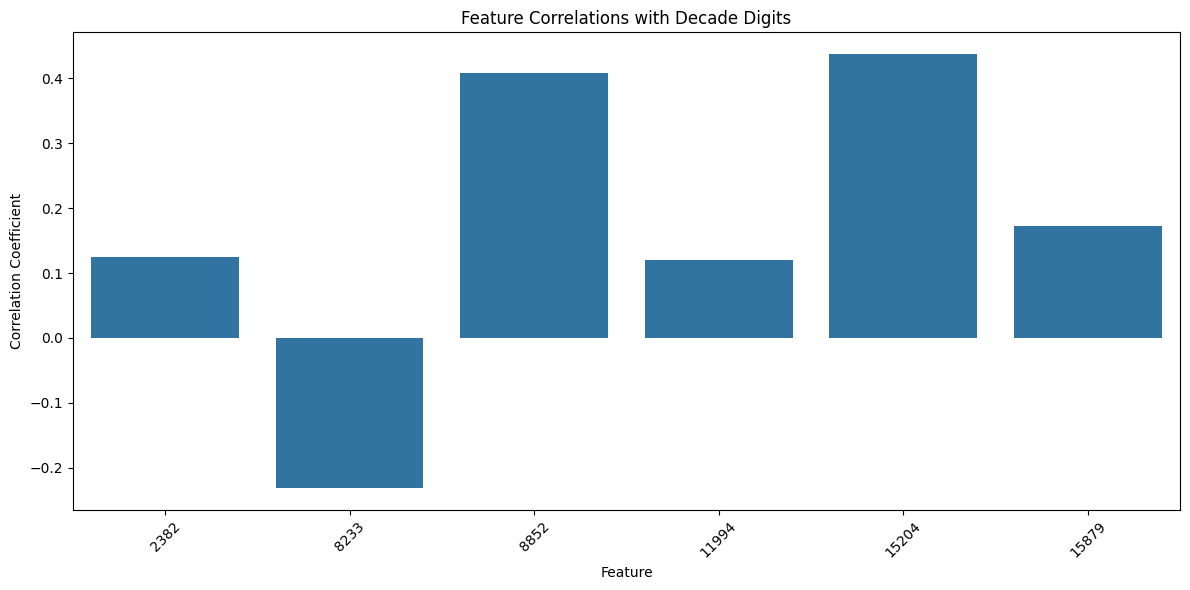


Top 5 features by absolute correlation:
   feature  correlation  abs_correlation
0    15204     0.437459         0.437459
4     8852     0.408032         0.408032
2     8233    -0.230966         0.230966
1    15879     0.172092         0.172092
3     2382     0.124829         0.124829


In [9]:
def plot_decade_feature_correlations(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs=False
):
    # Function to extract decade digits (first 3 digits of year)
    def extract_decade_digits(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = years[0]
            return int(year[:3])  # First three digits
        return None

    # Extract decade digits
    pca_df["decade_digits"] = pca_df["context"].apply(extract_decade_digits)

    # Get feature activations
    feature_activations = results.all_graph_feature_acts.cpu().numpy()

    # Calculate correlations for each feature
    correlations = []
    valid_mask = ~pca_df["decade_digits"].isna()

    for i, feature in enumerate(fs_splitting_nodes):
        if valid_mask.any():
            corr = np.corrcoef(
                pca_df.loc[valid_mask, "decade_digits"],
                feature_activations[valid_mask, i],
            )[0, 1]
            correlations.append({"feature": feature, "correlation": corr})

    # Create DataFrame and sort by absolute correlation
    corr_df = pd.DataFrame(correlations)
    corr_df["abs_correlation"] = corr_df["correlation"].abs()
    corr_df = corr_df.sort_values("abs_correlation", ascending=False)

    # Plot correlations
    plt.figure(figsize=(12, 6))
    sns.barplot(data=corr_df, x="feature", y="correlation")
    plt.xticks(rotation=45)
    plt.title("Feature Correlations with Decade Digits")
    plt.xlabel("Feature")
    plt.ylabel("Correlation Coefficient")
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/decade_feature_correlations.png", dpi=300, bbox_inches="tight"
        )

    plt.show()
    plt.close()

    # Return the correlation DataFrame
    return corr_df


# Call the function
corr_df = plot_decade_feature_correlations(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs
)
print("\nTop 5 features by absolute correlation:")
print(corr_df.head())

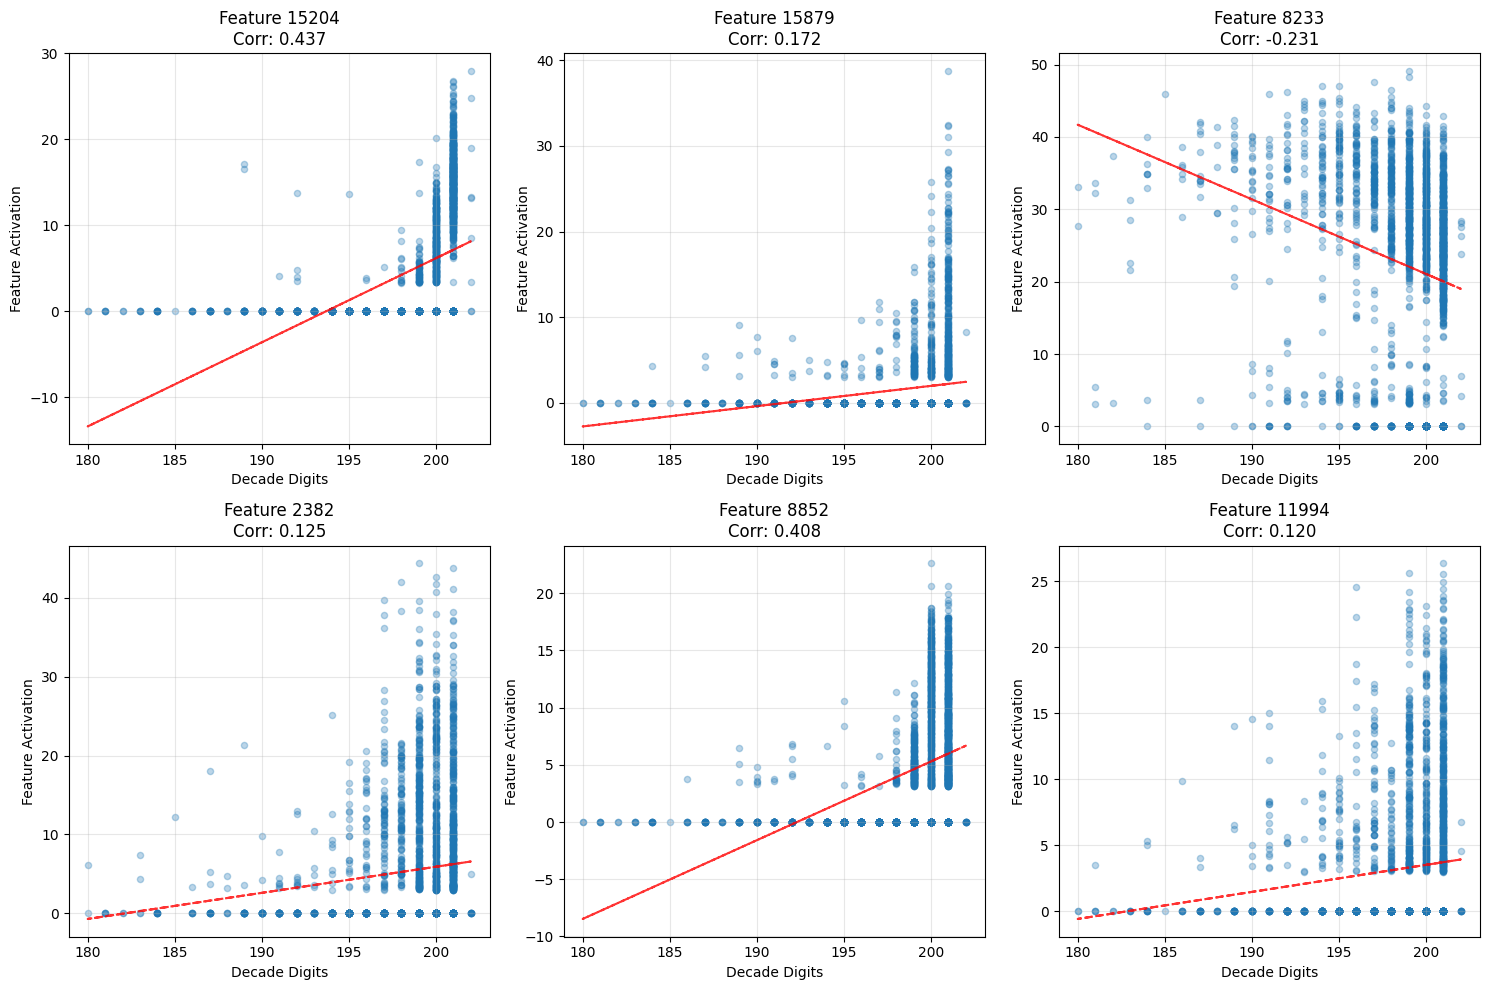

In [22]:
def plot_decade_feature_scatters(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs=False
):
    # Function to extract decade digits
    def extract_decade_digits(context):
        context = context.replace("|", "")
        years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
        if years:
            year = years[0]
            return int(year[:3])  # First three digits
        return None

    # Extract decade digits
    pca_df["decade_digits"] = pca_df["context"].apply(extract_decade_digits)

    # Get feature activations
    feature_activations = results.all_graph_feature_acts.cpu().numpy()

    # Calculate number of rows and columns for subplots
    n_features = len(fs_splitting_nodes)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # Valid mask for non-null decade digits
    valid_mask = ~pca_df["decade_digits"].isna()
    i = None
    for i, (feature, ax) in enumerate(zip(fs_splitting_nodes, axes)):
        # Get data for this feature
        x = pca_df.loc[valid_mask, "decade_digits"]
        y = feature_activations[valid_mask, i]

        # Calculate correlation
        corr = np.corrcoef(x, y)[0, 1]

        # Create scatter plot
        ax.scatter(x, y, alpha=0.3, s=20)

        # Add trend line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--", alpha=0.8)

        ax.set_title(f"Feature {feature}\nCorr: {corr:.3f}")
        ax.set_xlabel("Decade Digits")
        ax.set_ylabel("Feature Activation")

        # Add grid
        ax.grid(True, alpha=0.3)

    if i is None:
        i = len(fs_splitting_nodes)
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/decade_feature_scatters.png", dpi=300, bbox_inches="tight"
        )

    plt.show()
    plt.close()


# Call the function
plot_decade_feature_scatters(pca_df, results, fs_splitting_nodes, pca_path, save_figs)

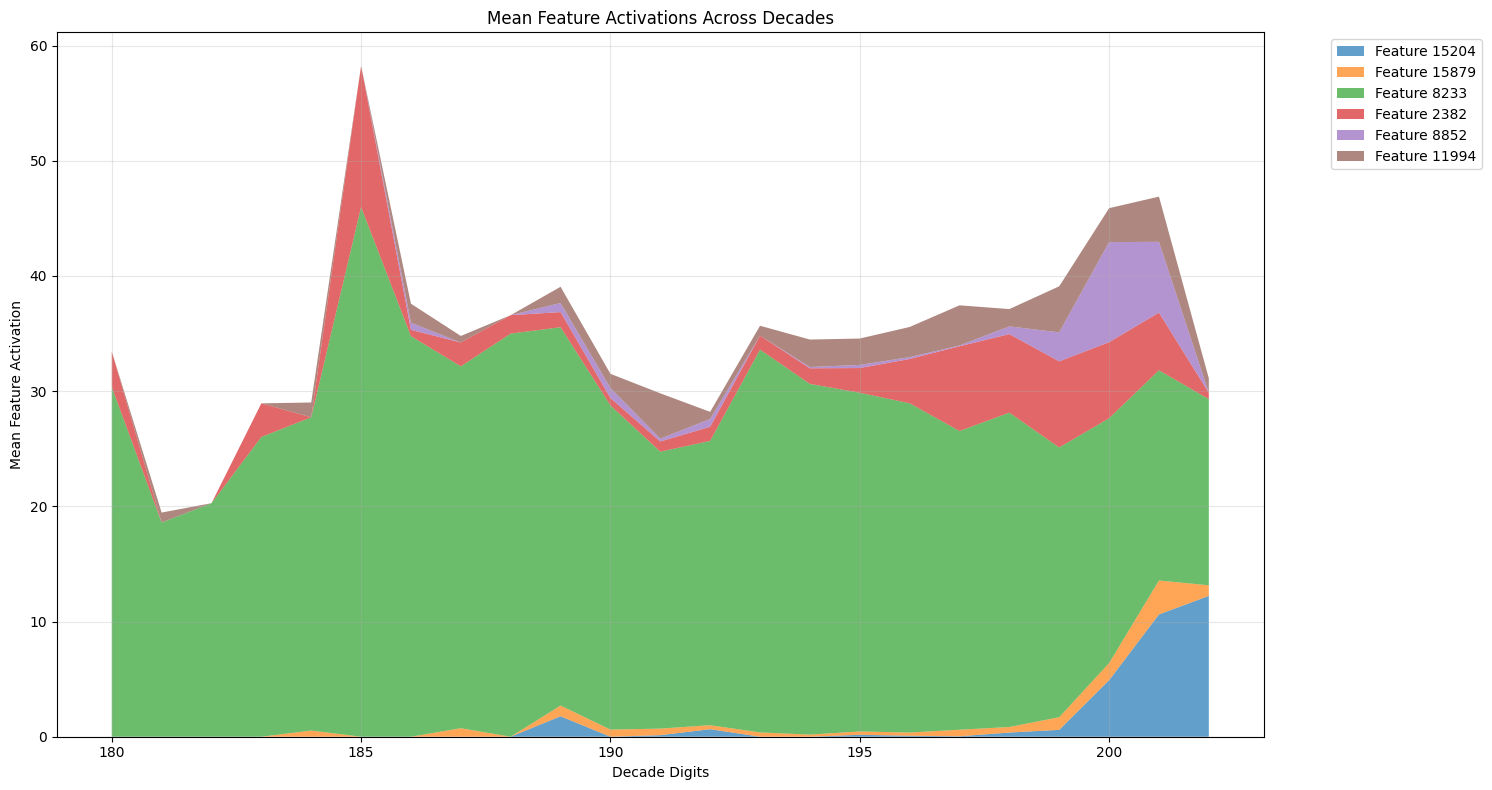

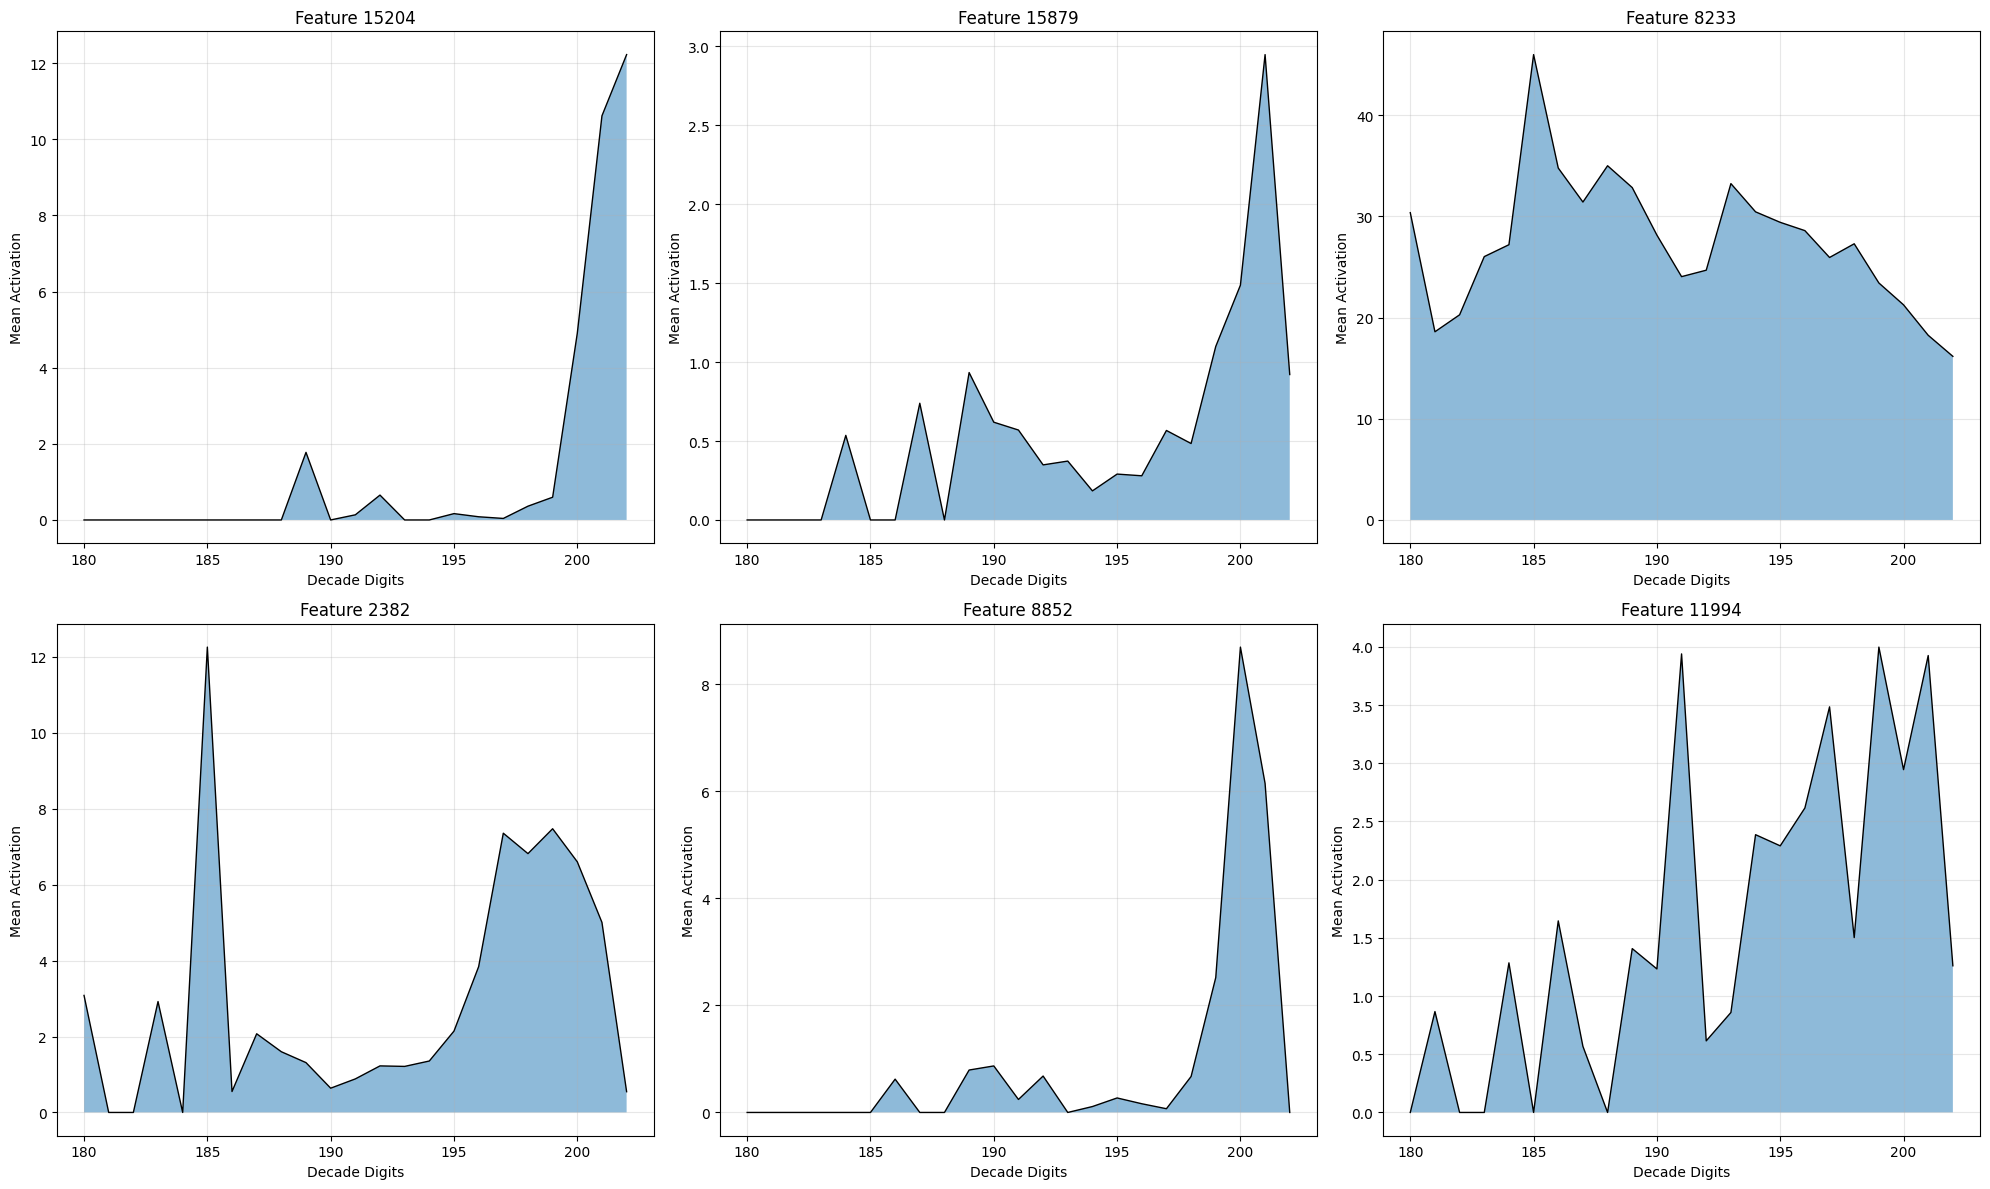


Mean activation by decade digits:
                   15204     15879       8233       2382      8852     11994
decade_digits                                                               
180.0           0.000000  0.000000  30.360910   3.082470  0.000000  0.000000
181.0           0.000000  0.000000  18.592377   0.000000  0.000000  0.866695
182.0           0.000000  0.000000  20.269838   0.000000  0.000000  0.000000
183.0           0.000000  0.000000  26.019470   2.921223  0.000000  0.000000
184.0           0.000000  0.535805  27.193237   0.000000  0.000000  1.285235
185.0           0.000000  0.000000  45.977165  12.256941  0.000000  0.000000
186.0           0.000000  0.000000  34.769382   0.551252  0.621911  1.645806
187.0           0.000000  0.739293  31.410053   2.072338  0.000000  0.567911
188.0           0.000000  0.000000  34.995888   1.599383  0.000000  0.000000
189.0           1.775379  0.933695  32.837009   1.312454  0.792243  1.407644
190.0           0.000000  0.619207  28.14

In [11]:
def plot_decade_feature_area(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs=False
):
    # Extract decade digits if not already done
    if "decade_digits" not in pca_df.columns:

        def extract_decade_digits(context):
            context = context.replace("|", "")
            years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
            if years:
                year = years[0]
                return int(year[:3])
            return None

        pca_df["decade_digits"] = pca_df["context"].apply(extract_decade_digits)

    # Get feature activations
    feature_activations = results.all_graph_feature_acts.cpu().numpy()

    # Create DataFrame with decade digits and feature activations
    activation_df = pd.DataFrame(feature_activations, columns=fs_splitting_nodes)
    activation_df["decade_digits"] = pca_df["decade_digits"]

    # Remove rows with no decade digits
    activation_df = activation_df.dropna(subset=["decade_digits"])

    # Calculate mean activation for each decade digit
    mean_activations = activation_df.groupby("decade_digits")[fs_splitting_nodes].mean()

    # Sort by decade digits
    mean_activations = mean_activations.sort_index()

    # Create the area plot
    plt.figure(figsize=(15, 8))

    # Plot stacked area chart
    plt.stackplot(
        mean_activations.index,
        mean_activations.T,
        labels=[f"Feature {f}" for f in fs_splitting_nodes],
        alpha=0.7,
    )

    # Customize the plot
    plt.title("Mean Feature Activations Across Decades")
    plt.xlabel("Decade Digits")
    plt.ylabel("Mean Feature Activation")
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    if save_figs:
        plt.savefig(f"{pca_path}/decade_feature_area.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

    # Also create individual area plots for each feature
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    i = None
    for i, feature in enumerate(fs_splitting_nodes):
        ax = axes[i]
        ax.fill_between(mean_activations.index, mean_activations[feature], alpha=0.5)
        ax.plot(mean_activations.index, mean_activations[feature], "k-", linewidth=1)

        ax.set_title(f"Feature {feature}")
        ax.set_xlabel("Decade Digits")
        ax.set_ylabel("Mean Activation")
        ax.grid(True, alpha=0.3)
    if i is None:
        i = len(fs_splitting_nodes)
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/decade_feature_area_individual.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

    return mean_activations


# Call the function
mean_activations = plot_decade_feature_area(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs
)

# Print summary statistics
print("\nMean activation by decade digits:")
print(mean_activations)

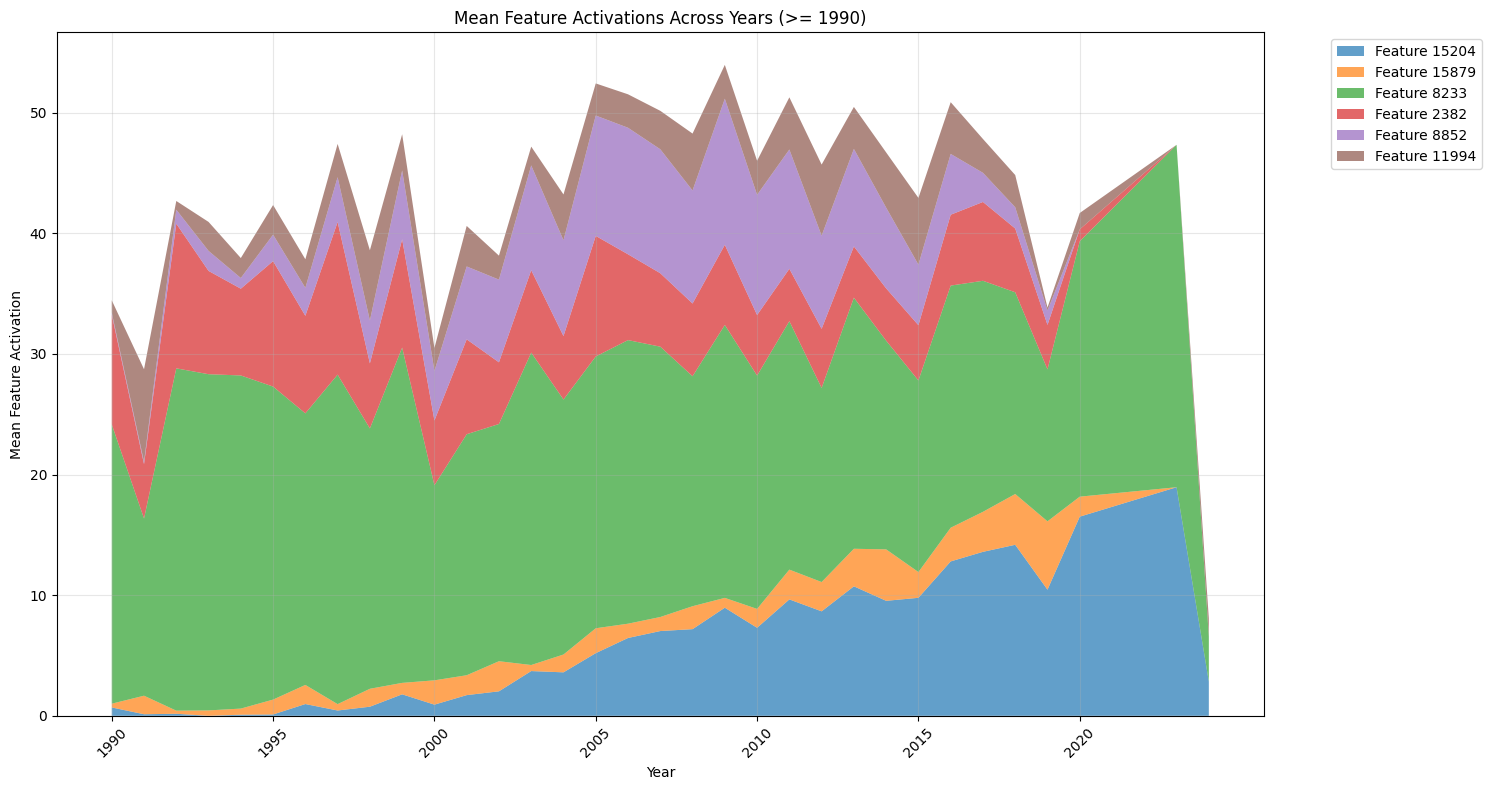

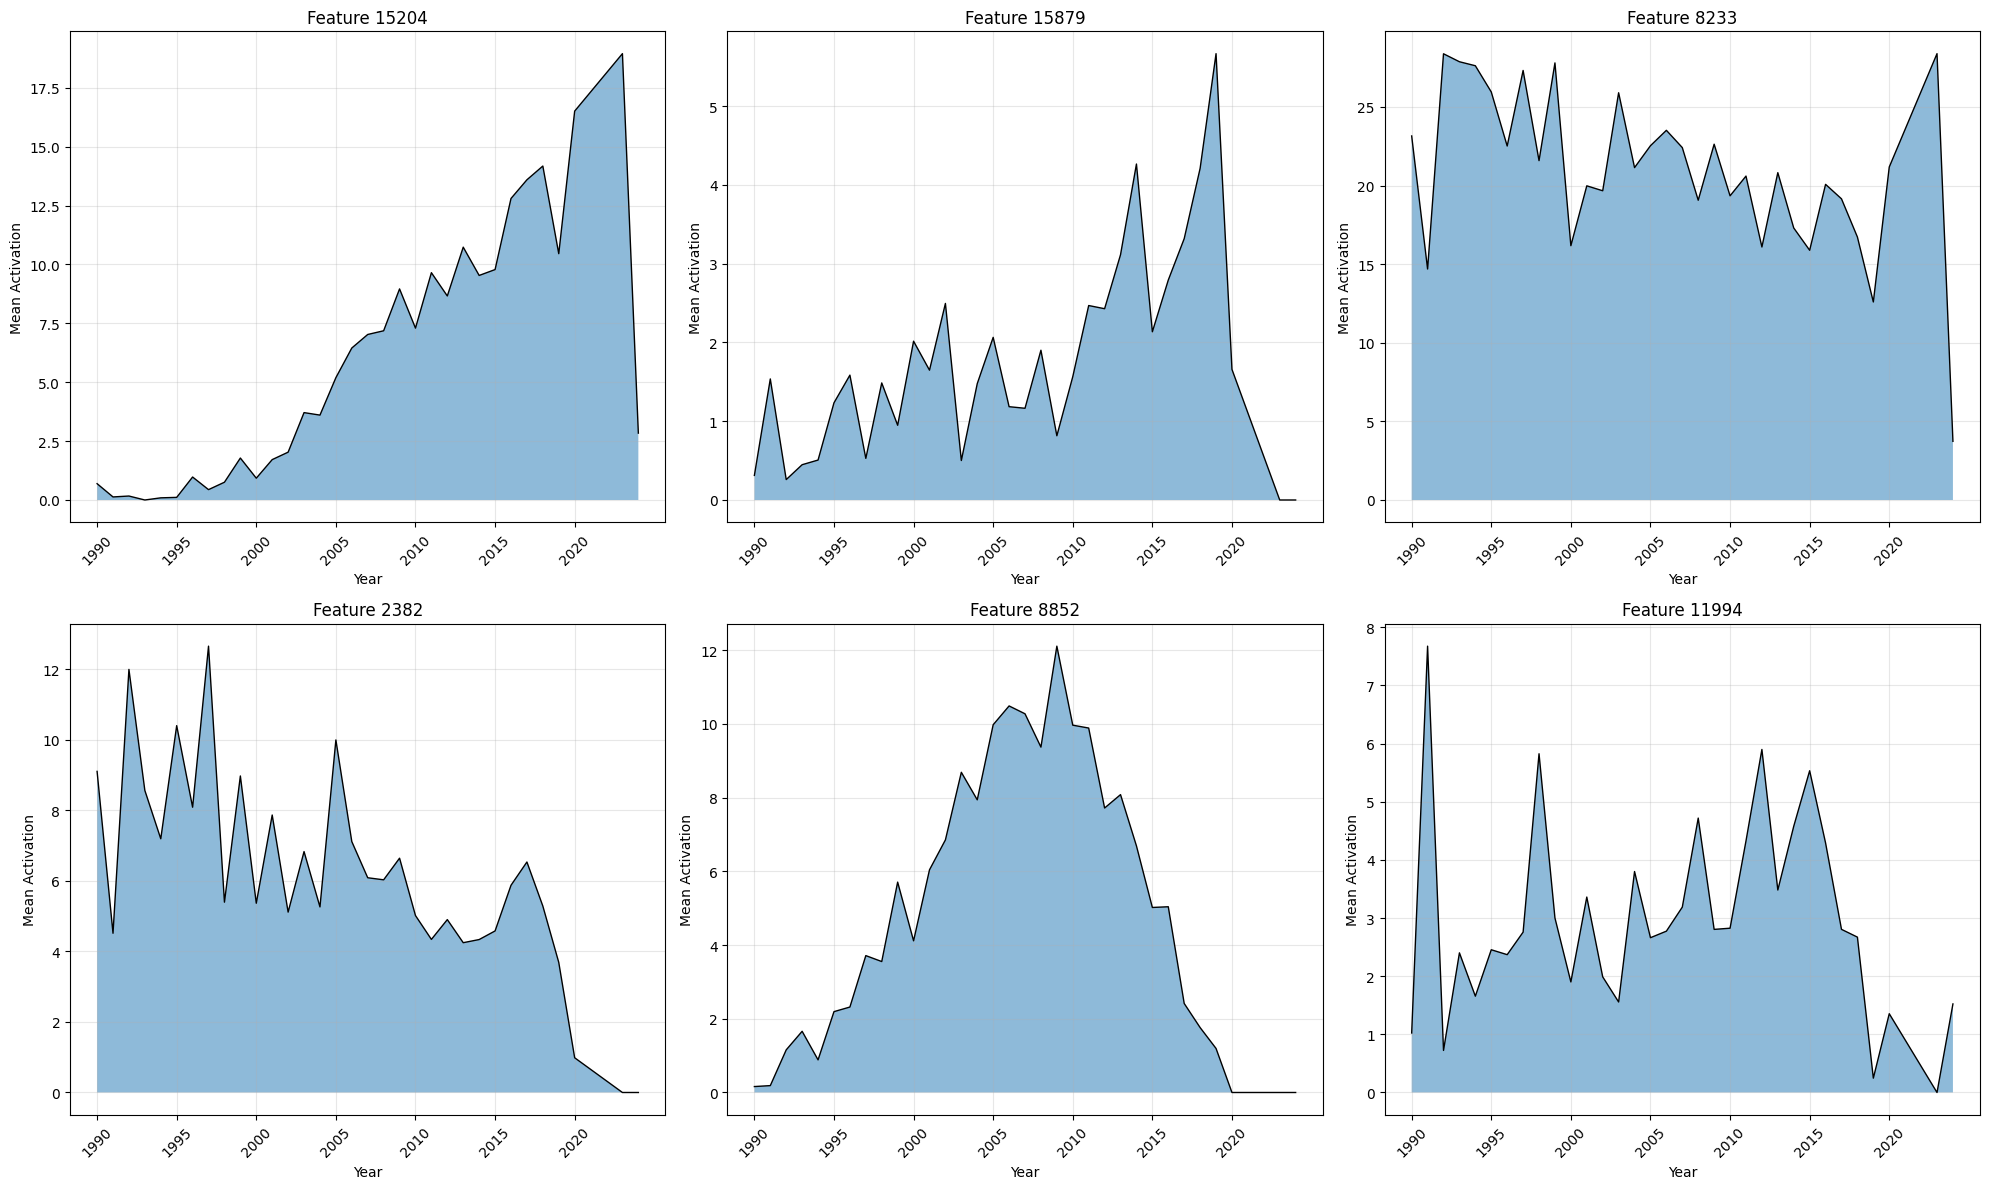


Mean activation by year (>= 1990):
            15204     15879       8233       2382       8852     11994
year                                                                  
1990.0   0.692717  0.312120  23.151033   9.102661   0.161039  1.023060
1991.0   0.129512  1.536679  14.689384   4.513959   0.186712  7.674798
1992.0   0.168394  0.259071  28.377262  11.993911   1.156984  0.723255
1993.0   0.000000  0.447915  27.870625   8.562269   1.660897  2.401218
1994.0   0.091467  0.507053  27.616056   7.192652   0.885391  1.656135
1995.0   0.111065  1.233434  25.949362  10.399592   2.193911  2.454447
1996.0   0.975240  1.585072  22.511282   8.087164   2.319026  2.370003
1997.0   0.439818  0.528257  27.316404  12.653020   3.714359  2.757576
1998.0   0.754777  1.486014  21.581268   5.395111   3.553226  5.824767
1999.0   1.781092  0.948375  27.796715   8.973190   5.708630  3.000936
2000.0   0.925644  2.015758  16.172405   5.365225   4.115797  1.900890
2001.0   1.714579  1.648083  19.979488   

In [23]:
def plot_decade_feature_area(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs=False, min_year=1990
):
    # Extract full year if not already done
    if "year" not in pca_df.columns:

        def extract_year(context):
            context = context.replace("|", "")
            years = re.findall(r"\b(1[89][0-9]{2}|20[0-2][0-9])\b", context)
            if years:
                return int(years[0])
            return None

        pca_df["year"] = pca_df["context"].apply(extract_year)

    # Get feature activations
    feature_activations = results.all_graph_feature_acts.cpu().numpy()

    # Create DataFrame with years and feature activations
    activation_df = pd.DataFrame(feature_activations, columns=fs_splitting_nodes)
    activation_df["year"] = pca_df["year"]

    # Remove rows with no year and filter for years >= min_year
    activation_df = activation_df.dropna(subset=["year"])
    activation_df = activation_df[activation_df["year"] >= min_year]

    # Calculate mean activation for each year
    mean_activations = activation_df.groupby("year")[fs_splitting_nodes].mean()

    # Sort by year
    mean_activations = mean_activations.sort_index()

    # Create the area plot
    plt.figure(figsize=(15, 8))

    # Plot stacked area chart
    plt.stackplot(
        mean_activations.index,
        mean_activations.T,
        labels=[f"Feature {f}" for f in fs_splitting_nodes],
        alpha=0.7,
    )

    # Customize the plot
    plt.title(f"Mean Feature Activations Across Years (>= {min_year})")
    plt.xlabel("Year")
    plt.ylabel("Mean Feature Activation")
    plt.grid(True, alpha=0.3)

    # Set x-axis ticks to show every 5 years
    plt.xticks(np.arange(min_year, max(mean_activations.index) + 1, 5), rotation=45)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/decade_feature_area_post{min_year}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

    # Also create individual area plots for each feature
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, feature in enumerate(fs_splitting_nodes):
        ax = axes[i]
        ax.fill_between(mean_activations.index, mean_activations[feature], alpha=0.5)
        ax.plot(mean_activations.index, mean_activations[feature], "k-", linewidth=1)

        ax.set_title(f"Feature {feature}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Mean Activation")
        ax.grid(True, alpha=0.3)

        # Set x-axis ticks to show every 5 years
        ax.set_xticks(np.arange(min_year, max(mean_activations.index) + 1, 5))
        ax.tick_params(axis="x", rotation=45)

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/decade_feature_area_individual_post{min_year}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

    return mean_activations


# Call the function
mean_activations = plot_decade_feature_area(
    pca_df, results, fs_splitting_nodes, pca_path, save_figs, min_year=1990
)

# Print summary statistics
print("\nMean activation by year (>= 1990):")
print(mean_activations)

Training RMSE: 21.67 years
Test RMSE: 23.42 years
Training R²: 0.495
Test R²: 0.477


/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


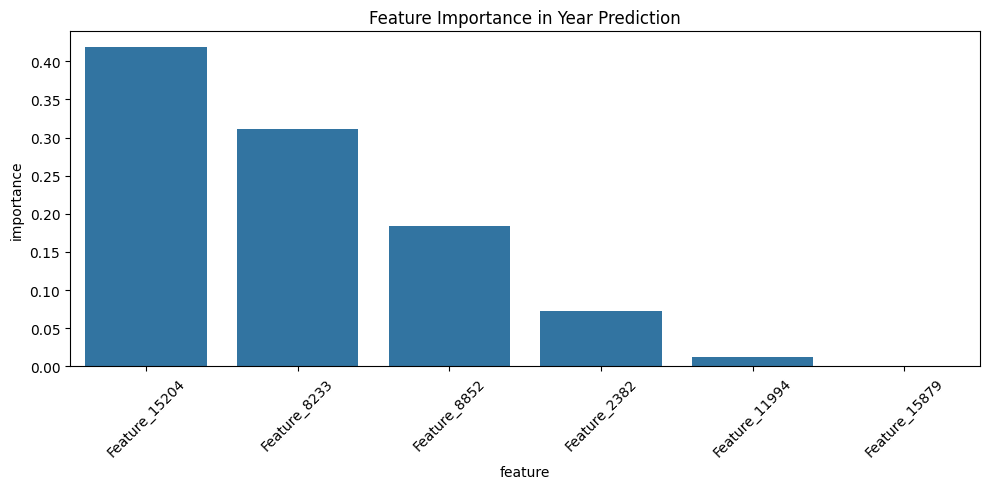

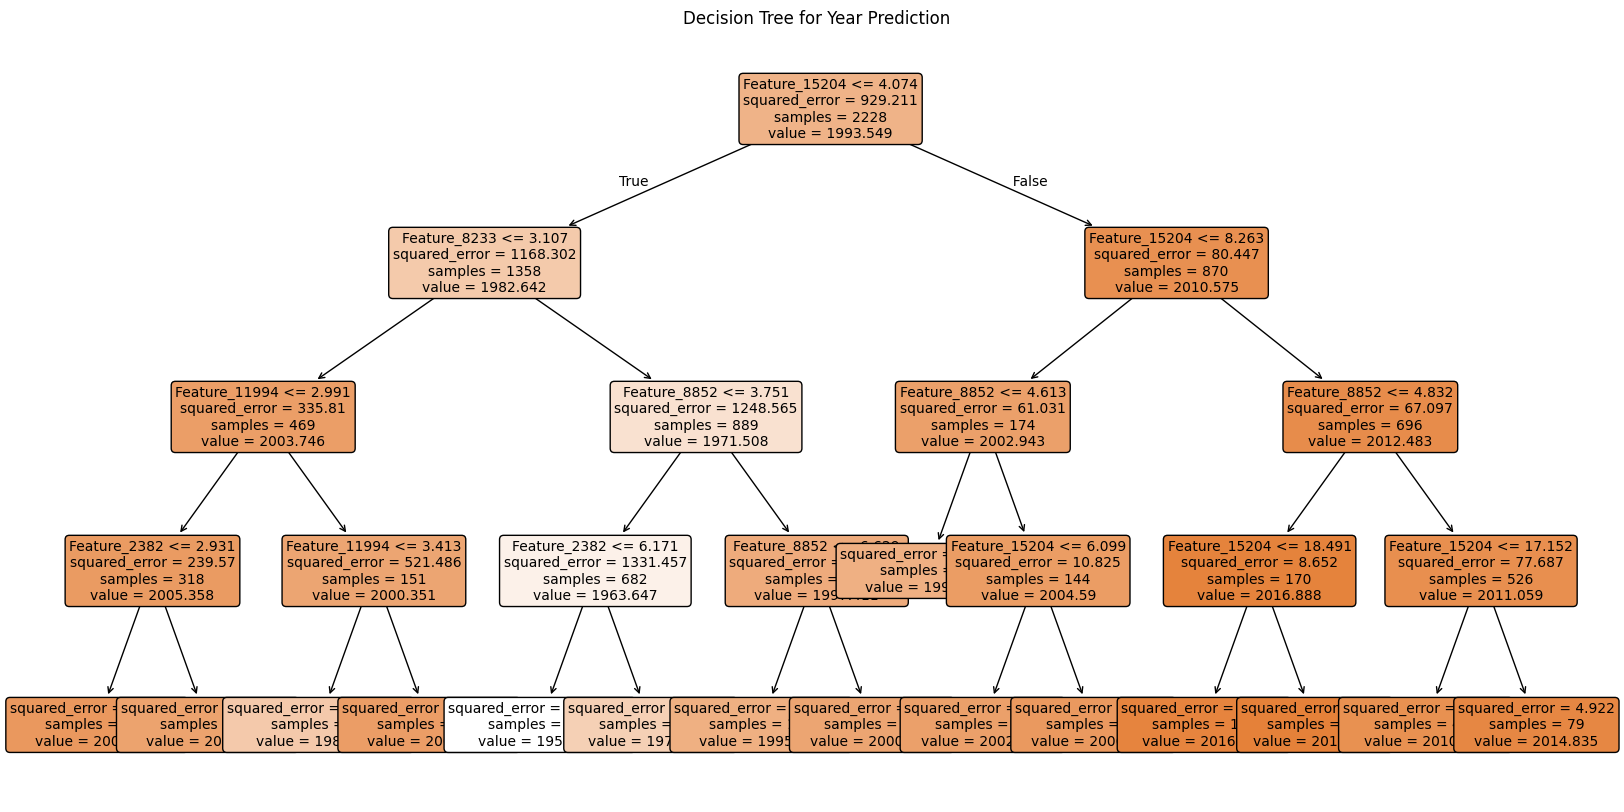

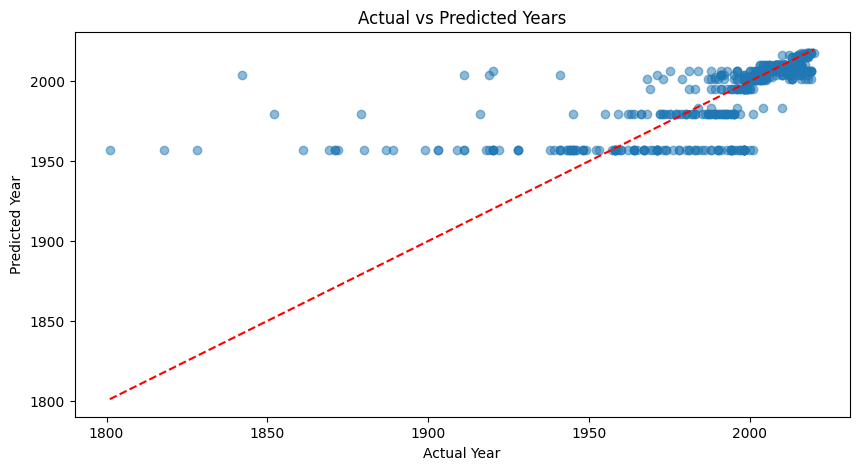

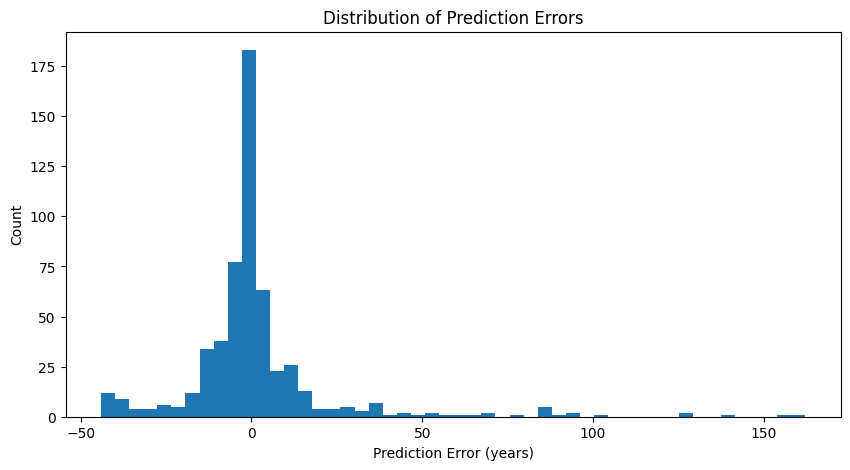


Example predictions:
      Actual  Predicted  Error
7329  1988.0     1982.9   -5.1
6709  1998.0     1956.9  -41.1
2039  1998.0     1995.3   -2.7
7214  2017.0     2017.9    0.9
316   1991.0     1995.3    4.3
3749  2014.0     2010.4   -3.6
5155  2007.0     2006.6   -0.4
5336  2012.0     2006.6   -5.4
3663  2010.0     2010.4    0.4
1492  1981.0     1956.9  -24.1


In [15]:
# Prepare the data
feature_activations = results.all_graph_feature_acts.cpu().numpy()

# Create DataFrame with years and feature activations
X = pd.DataFrame(
    feature_activations, columns=[f"Feature_{f}" for f in fs_splitting_nodes]
)
y = pca_df["year"].copy()

# Remove rows with no year
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)
tree.fit(X_train, y_train)

# Make predictions
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train, squared=False)  # RMSE
test_mse = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training RMSE: {train_mse:.2f} years")
print(f"Test RMSE: {test_mse:.2f} years")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

# Plot feature importances
importances = pd.DataFrame(
    {"feature": X.columns, "importance": tree.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importances, x="feature", y="importance")
plt.xticks(rotation=45)
plt.title("Feature Importance in Year Prediction")
plt.tight_layout()
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Year Prediction")
if save_figs:
    plt.savefig(f"{pca_path}/year_prediction_tree.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title("Actual vs Predicted Years")
if save_figs:
    plt.savefig(f"{pca_path}/year_prediction_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot prediction errors
errors = y_pred_test - y_test
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (years)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
if save_figs:
    plt.savefig(f"{pca_path}/year_prediction_errors.png", dpi=300, bbox_inches="tight")
plt.show()

# Print some example predictions
print("\nExample predictions:")
sample_idx = np.random.choice(len(y_test), 10)
examples = pd.DataFrame(
    {
        "Actual": y_test.iloc[sample_idx],
        "Predicted": y_pred_test[sample_idx],
        "Error": y_pred_test[sample_idx] - y_test.iloc[sample_idx],
    }
).round(1)
print(examples)

Training Accuracy: 0.404
Test Accuracy: 0.392


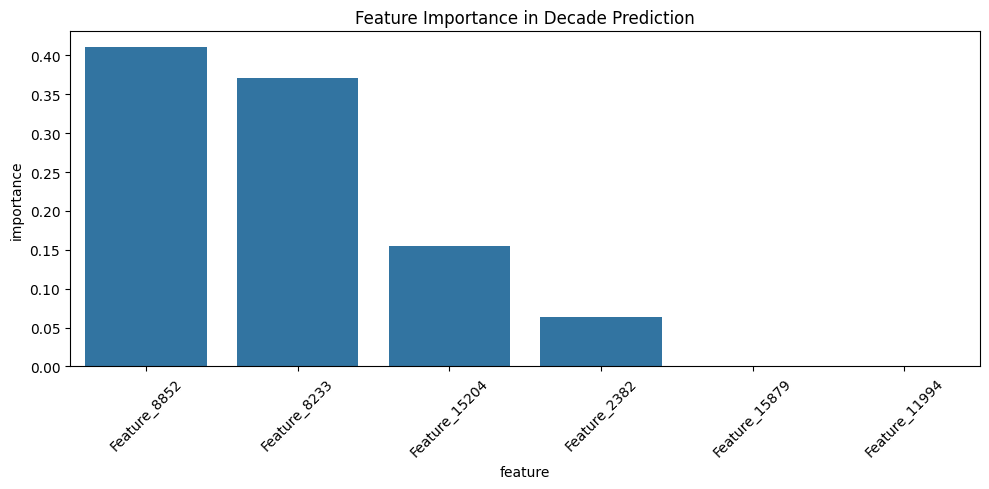

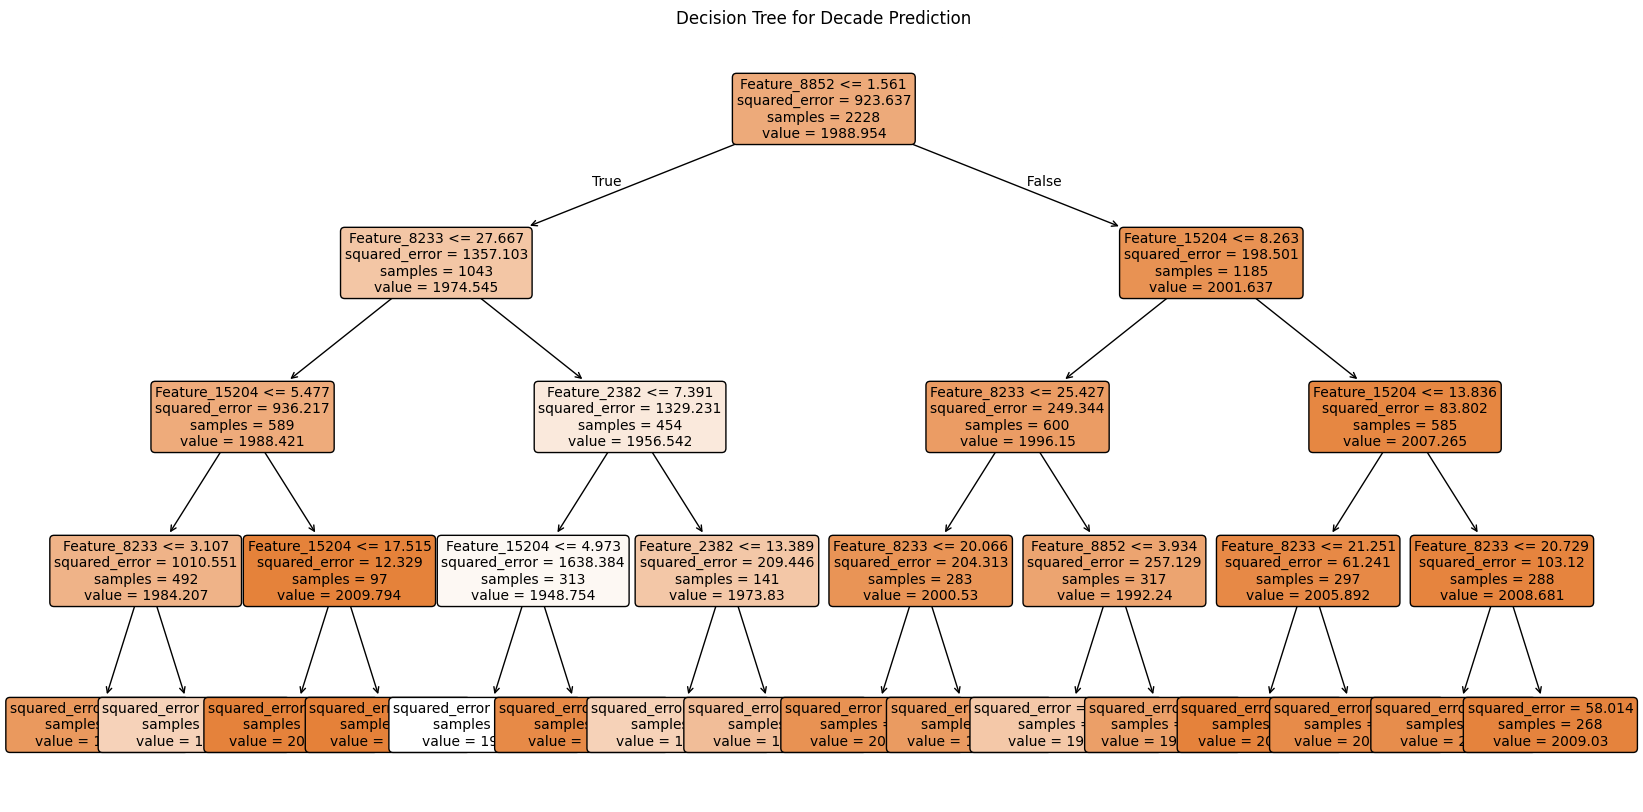

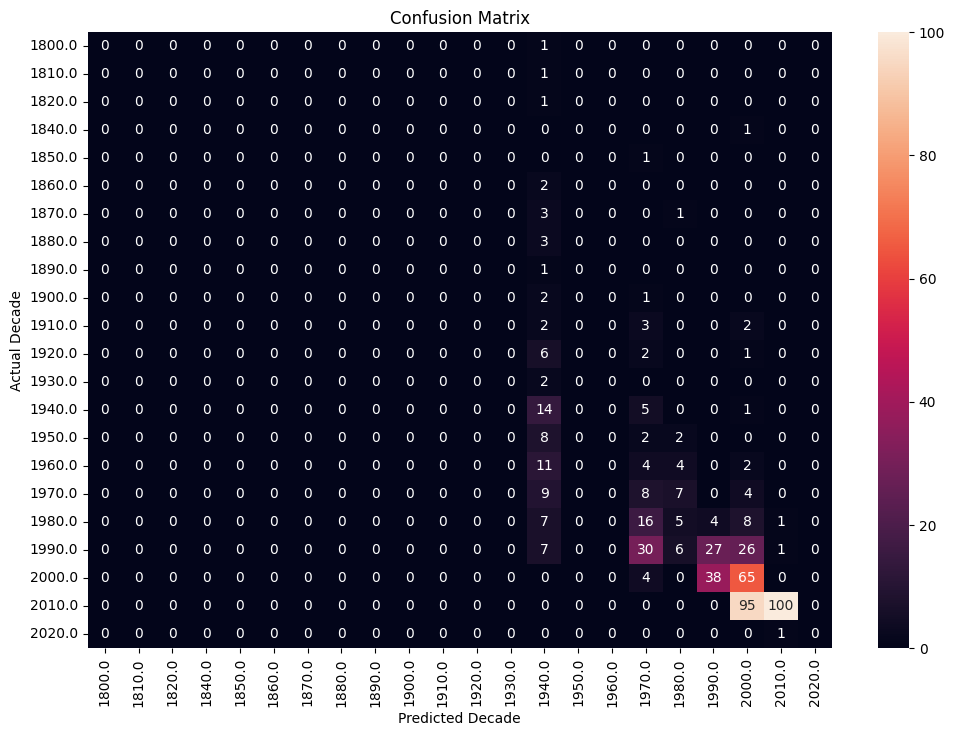

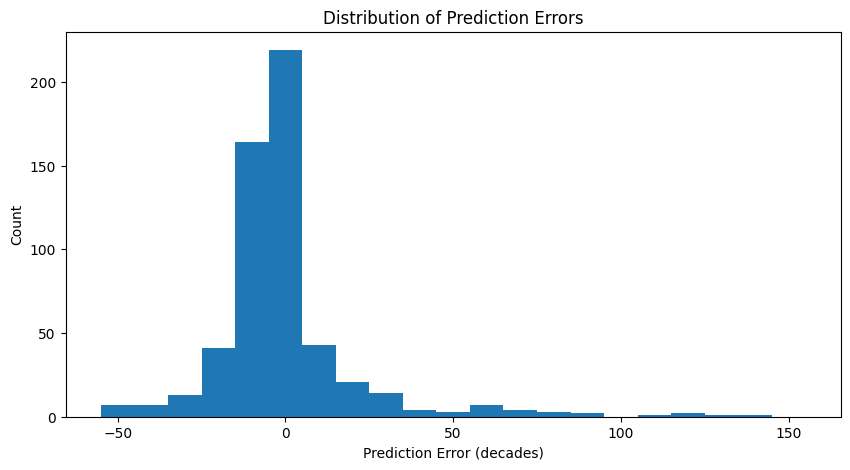


Example predictions:
      Actual  Predicted  Error
6340  2010.0     2000.0   -1.0
6166  1990.0     1990.0    0.0
5793  1990.0     2000.0    1.0
4799  2010.0     2000.0   -1.0
3597  1870.0     1940.0    7.0
3322  1990.0     1990.0    0.0
1467  1960.0     1940.0   -2.0
6044  1970.0     1980.0    1.0
2815  2000.0     1990.0   -1.0
6079  1880.0     1940.0    6.0

Per-decade accuracy:
1800s: 0.000 (n=1)
1810s: 0.000 (n=1)
1820s: 0.000 (n=1)
1840s: 0.000 (n=1)
1850s: 0.000 (n=1)
1860s: 0.000 (n=2)
1870s: 0.000 (n=4)
1880s: 0.000 (n=3)
1890s: 0.000 (n=1)
1900s: 0.000 (n=3)
1910s: 0.000 (n=7)
1920s: 0.000 (n=9)
1930s: 0.000 (n=2)
1940s: 0.700 (n=20)
1950s: 0.000 (n=12)
1960s: 0.000 (n=21)
1970s: 0.286 (n=28)
1980s: 0.122 (n=41)
1990s: 0.278 (n=97)
2000s: 0.607 (n=107)
2010s: 0.513 (n=195)
2020s: 0.000 (n=1)


In [16]:
# Prepare the data
feature_activations = results.all_graph_feature_acts.cpu().numpy()

# Create DataFrame with years and feature activations
X = pd.DataFrame(
    feature_activations, columns=[f"Feature_{f}" for f in fs_splitting_nodes]
)
y = pca_df["year"].copy()

# Remove rows with no year
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]

# Convert years to decades (e.g., 1987 -> 1980)
y = (y // 10) * 10

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)
tree.fit(X_train, y_train)

# Make predictions
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

# Round predictions to nearest decade
y_pred_train = np.round(y_pred_train / 10) * 10
y_pred_test = np.round(y_pred_test / 10) * 10

# Calculate metrics
train_accuracy = (y_pred_train == y_train).mean()
test_accuracy = (y_pred_test == y_test).mean()

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Plot feature importances
importances = pd.DataFrame(
    {"feature": X.columns, "importance": tree.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importances, x="feature", y="importance")
plt.xticks(rotation=45)
plt.title("Feature Importance in Decade Prediction")
plt.tight_layout()
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Decade Prediction")
if save_figs:
    plt.savefig(f"{pca_path}/decade_prediction_tree.png", dpi=300, bbox_inches="tight")
plt.show()

# Create confusion matrix
decades = sorted(np.unique(np.concatenate([y_test, y_pred_test])))
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=decades, yticklabels=decades)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Decade")
plt.ylabel("Actual Decade")
if save_figs:
    plt.savefig(
        f"{pca_path}/decade_prediction_confusion.png", dpi=300, bbox_inches="tight"
    )
plt.show()

# Plot prediction errors
errors = y_pred_test - y_test
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=np.arange(min(errors) - 5, max(errors) + 5, 10))
plt.xlabel("Prediction Error (decades)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
if save_figs:
    plt.savefig(
        f"{pca_path}/decade_prediction_errors.png", dpi=300, bbox_inches="tight"
    )
plt.show()

# Print some example predictions
print("\nExample predictions:")
sample_idx = np.random.choice(len(y_test), 10)
examples = pd.DataFrame(
    {
        "Actual": y_test.iloc[sample_idx],
        "Predicted": y_pred_test[sample_idx],
        "Error": (y_pred_test[sample_idx] - y_test.iloc[sample_idx]) / 10,
    }
).round(1)
print(examples)

# Print per-decade accuracy
print("\nPer-decade accuracy:")
for decade in decades:
    mask = y_test == decade
    if mask.any():
        accuracy = (y_pred_test[mask] == y_test[mask]).mean()
        n_samples = mask.sum()
        print(f"{int(decade)}s: {accuracy:.3f} (n={n_samples})")

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Use


Linear Regression Results:
Training RMSE: 23.48 years
Test RMSE: 24.44 years
Training R²: 0.407
Test R²: 0.430

Ridge Results:
Training RMSE: 23.48 years
Test RMSE: 24.44 years
Training R²: 0.407
Test R²: 0.430

Lasso Results:
Training RMSE: 23.48 years
Test RMSE: 24.46 years
Training R²: 0.406
Test R²: 0.429


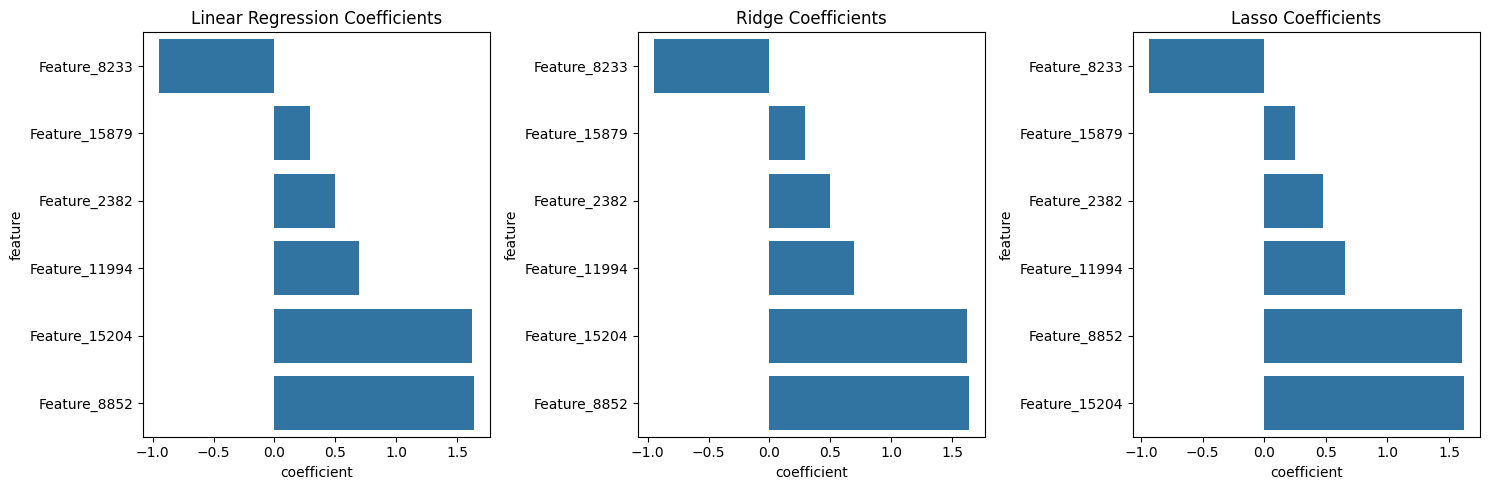

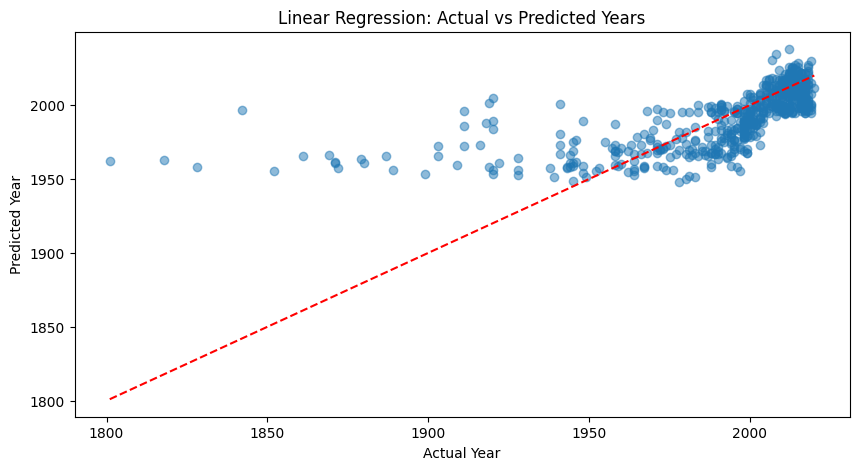

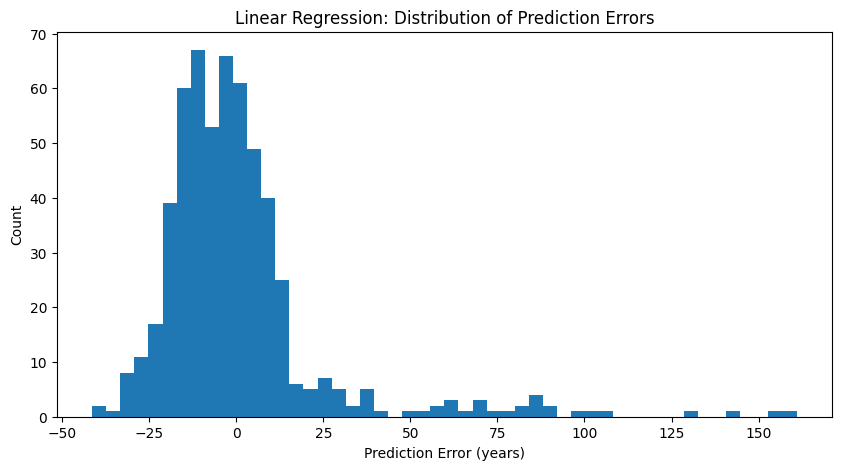

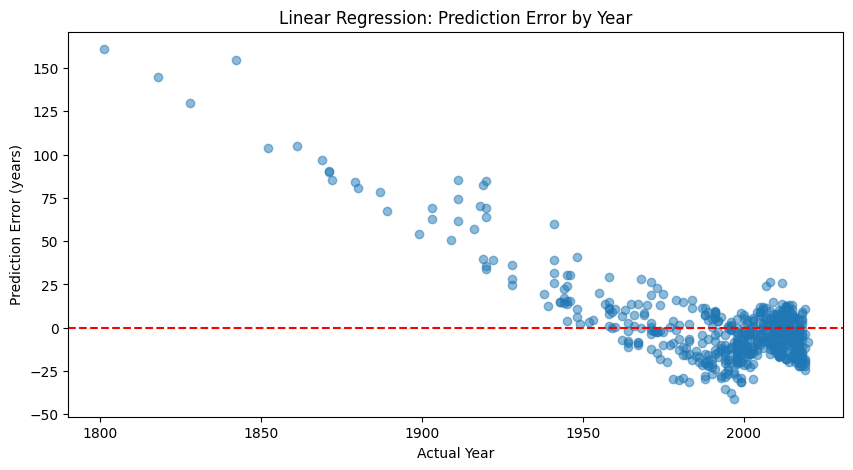


Linear Regression Example predictions:
      Actual    Predicted  Error
7159  1962.0  1954.800049   -7.2
5996  1889.0  1956.400024   67.4
6593  1999.0  1987.599976  -11.4
3597  1871.0  1961.000000   90.0
5625  2008.0  2000.699951   -7.3
3152  2017.0  2008.599976   -8.4
551   2019.0  1996.900024  -22.1
7151  1943.0  1957.699951   14.7
6245  2006.0  1997.800049   -8.2
5962  2001.0  1993.099976   -7.9

Error statistics:
Mean absolute error: 14.80 years
Median absolute error: 10.12 years
90th percentile absolute error: 28.01 years


In [17]:
# Prepare the data
feature_activations = results.all_graph_feature_acts.cpu().numpy()
X = pd.DataFrame(
    feature_activations, columns=[f"Feature_{f}" for f in fs_splitting_nodes]
)
y = pca_df["year"].copy()

# Remove rows with no year
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train different linear models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
}

results_dict = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    results_dict[name] = {
        "model": model,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "coefficients": model.coef_,
        "y_pred_test": y_pred_test,
    }

    print(f"\n{name} Results:")
    print(f"Training RMSE: {train_rmse:.2f} years")
    print(f"Test RMSE: {test_rmse:.2f} years")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Test R²: {test_r2:.3f}")

# Plot coefficients for each model
plt.figure(figsize=(15, 5))
for i, (name, results) in enumerate(results_dict.items()):
    plt.subplot(1, 3, i + 1)
    coef_df = pd.DataFrame(
        {"feature": X.columns, "coefficient": results["coefficients"]}
    ).sort_values("coefficient", ascending=True)

    sns.barplot(data=coef_df, x="coefficient", y="feature")
    plt.title(f"{name} Coefficients")
    plt.tight_layout()
plt.show()

# Plot actual vs predicted for best model
best_model_name = min(results_dict.items(), key=lambda x: x[1]["test_rmse"])[0]
best_results = results_dict[best_model_name]

plt.figure(figsize=(10, 5))
plt.scatter(y_test, best_results["y_pred_test"], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title(f"{best_model_name}: Actual vs Predicted Years")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_scatter.png", dpi=300, bbox_inches="tight"
    )
plt.show()

# Plot prediction errors
errors = best_results["y_pred_test"] - y_test
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (years)")
plt.ylabel("Count")
plt.title(f"{best_model_name}: Distribution of Prediction Errors")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_errors.png", dpi=300, bbox_inches="tight"
    )
plt.show()

# Plot error by actual year
plt.figure(figsize=(10, 5))
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Actual Year")
plt.ylabel("Prediction Error (years)")
plt.title(f"{best_model_name}: Prediction Error by Year")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_errors_by_year.png", dpi=300, bbox_inches="tight"
    )
plt.show()

# Print example predictions
print(f"\n{best_model_name} Example predictions:")
sample_idx = np.random.choice(len(y_test), 10)
examples = pd.DataFrame(
    {
        "Actual": y_test.iloc[sample_idx],
        "Predicted": best_results["y_pred_test"][sample_idx],
        "Error": best_results["y_pred_test"][sample_idx] - y_test.iloc[sample_idx],
    }
).round(1)
print(examples)

# Calculate error statistics
print("\nError statistics:")
print(f"Mean absolute error: {np.abs(errors).mean():.2f} years")
print(f"Median absolute error: {np.median(np.abs(errors)):.2f} years")
print(f"90th percentile absolute error: {np.percentile(np.abs(errors), 90):.2f} years")

Number of samples after filtering (>= 1950): 2547
Year range: 1951.0 to 2024.0

Linear Regression Results (1950+):
Training RMSE: 10.27 years
Test RMSE: 9.65 years
Training R²: 0.592
Test R²: 0.596

Ridge Results (1950+):
Training RMSE: 10.27 years
Test RMSE: 9.65 years
Training R²: 0.592
Test R²: 0.596

Lasso Results (1950+):
Training RMSE: 10.28 years
Test RMSE: 9.65 years
Training R²: 0.591
Test R²: 0.596


/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Use

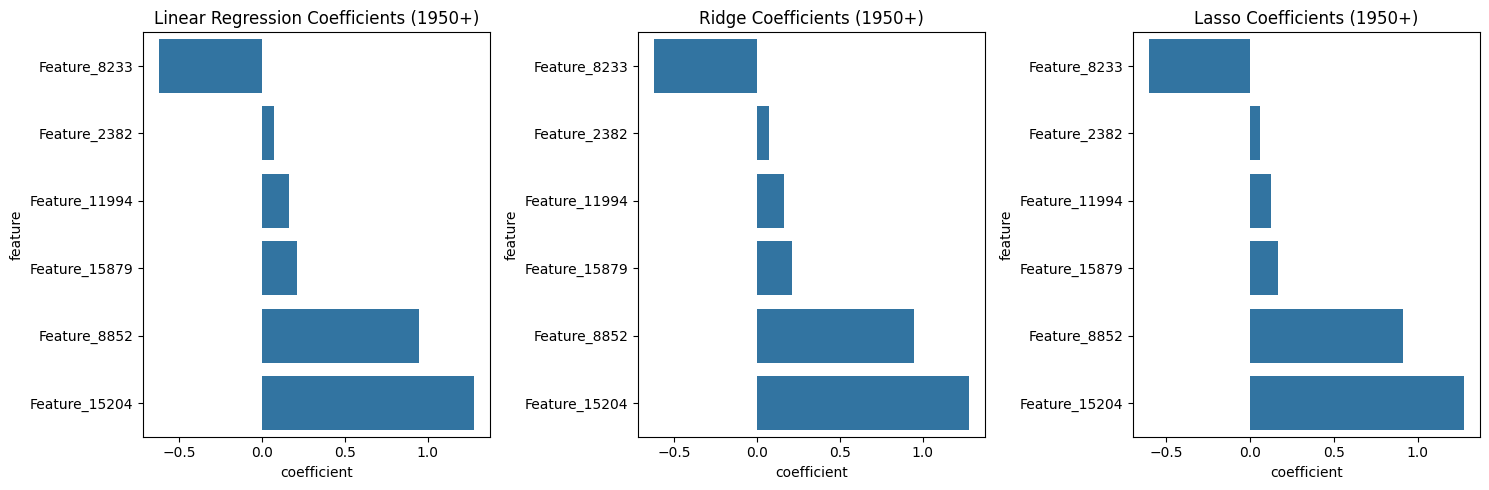

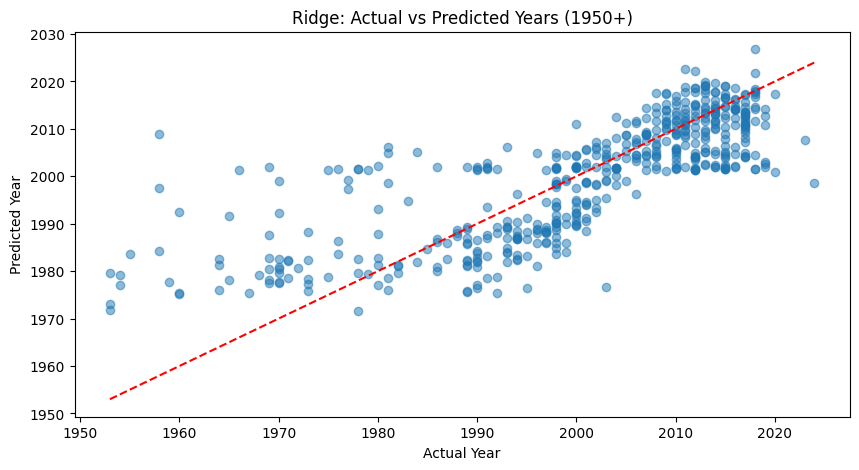

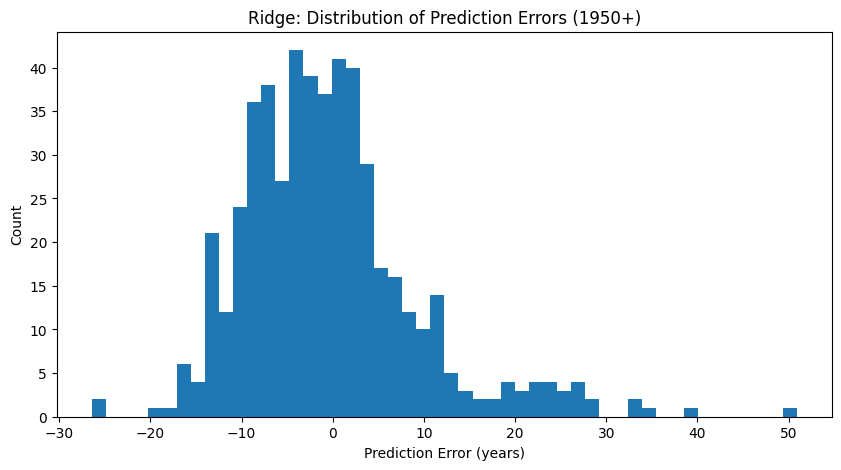

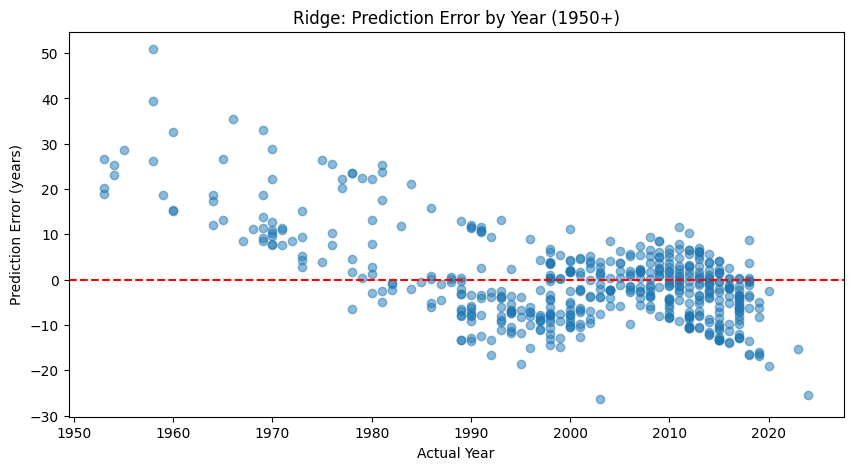


Ridge Example predictions (1950+):
      Actual    Predicted  Error
7317  1991.0  1993.599976    2.6
2936  2011.0  2011.800049    0.8
6749  1989.0  1988.800049   -0.2
2749  1970.0  1999.000000   29.0
5377  2005.0  2005.300049    0.3
6939  2009.0  2014.000000    5.0
5782  2000.0  2004.199951    4.2
2045  1998.0  1997.800049   -0.2
3767  2001.0  1990.599976  -10.4
3570  1989.0  1975.800049  -13.2

Error statistics (1950+):
Mean absolute error: 7.10 years
Median absolute error: 5.65 years
90th percentile absolute error: 13.81 years

Error by decade:
1950s: 
  Mean absolute error: 27.80 years
  Samples: 10
1960s: 
  Mean absolute error: 17.69 years
  Samples: 17
1970s: 
  Mean absolute error: 12.40 years
  Samples: 31
1980s: 
  Mean absolute error: 6.89 years
  Samples: 40
1990s: 
  Mean absolute error: 7.61 years
  Samples: 100
2000s: 
  Mean absolute error: 4.38 years
  Samples: 121
2010s: 
  Mean absolute error: 5.50 years
  Samples: 187
2020s: 
  Mean absolute error: 15.60 years
  Sam

In [24]:
# Prepare the data
feature_activations = results.all_graph_feature_acts.cpu().numpy()
X = pd.DataFrame(
    feature_activations, columns=[f"Feature_{f}" for f in fs_splitting_nodes]
)
y = pca_df["year"].copy()

# Remove rows with no year and filter for years >= 1950
valid_mask = ~y.isna() & (y >= 1950)
X = X[valid_mask]
y = y[valid_mask]

print(f"Number of samples after filtering (>= 1950): {len(y)}")
print(f"Year range: {y.min()} to {y.max()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train different linear models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
}

results_dict = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    results_dict[name] = {
        "model": model,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "coefficients": model.coef_,
        "y_pred_test": y_pred_test,
    }

    print(f"\n{name} Results (1950+):")
    print(f"Training RMSE: {train_rmse:.2f} years")
    print(f"Test RMSE: {test_rmse:.2f} years")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Test R²: {test_r2:.3f}")

# Plot coefficients for each model
plt.figure(figsize=(15, 5))
for i, (name, results) in enumerate(results_dict.items()):
    plt.subplot(1, 3, i + 1)
    coef_df = pd.DataFrame(
        {"feature": X.columns, "coefficient": results["coefficients"]}
    ).sort_values("coefficient", ascending=True)

    sns.barplot(data=coef_df, x="coefficient", y="feature")
    plt.title(f"{name} Coefficients (1950+)")
    plt.tight_layout()
plt.show()

# Plot actual vs predicted for best model
best_model_name = min(results_dict.items(), key=lambda x: x[1]["test_rmse"])[0]
best_results = results_dict[best_model_name]

plt.figure(figsize=(10, 5))
plt.scatter(y_test, best_results["y_pred_test"], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title(f"{best_model_name}: Actual vs Predicted Years (1950+)")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_scatter_1950plus.png",
        dpi=300,
        bbox_inches="tight",
    )
plt.show()

# Plot prediction errors
errors = best_results["y_pred_test"] - y_test
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (years)")
plt.ylabel("Count")
plt.title(f"{best_model_name}: Distribution of Prediction Errors (1950+)")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_errors_1950plus.png",
        dpi=300,
        bbox_inches="tight",
    )
plt.show()

# Plot error by actual year
plt.figure(figsize=(10, 5))
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Actual Year")
plt.ylabel("Prediction Error (years)")
plt.title(f"{best_model_name}: Prediction Error by Year (1950+)")
if save_figs:
    plt.savefig(
        f"{pca_path}/linear_prediction_errors_by_year_1950plus.png",
        dpi=300,
        bbox_inches="tight",
    )
plt.show()

# Print example predictions
print(f"\n{best_model_name} Example predictions (1950+):")
sample_idx = np.random.choice(len(y_test), 10)
examples = pd.DataFrame(
    {
        "Actual": y_test.iloc[sample_idx],
        "Predicted": best_results["y_pred_test"][sample_idx],
        "Error": best_results["y_pred_test"][sample_idx] - y_test.iloc[sample_idx],
    }
).round(1)
print(examples)

# Calculate error statistics
print("\nError statistics (1950+):")
print(f"Mean absolute error: {np.abs(errors).mean():.2f} years")
print(f"Median absolute error: {np.median(np.abs(errors)):.2f} years")
print(f"90th percentile absolute error: {np.percentile(np.abs(errors), 90):.2f} years")

# Calculate error by decade
print("\nError by decade:")
decades = np.floor(y_test / 10) * 10
for decade in sorted(decades.unique()):
    decade_mask = decades == decade
    decade_errors = errors[decade_mask]
    print(f"{int(decade)}s: ")
    print(f"  Mean absolute error: {np.abs(decade_errors).mean():.2f} years")
    print(f"  Samples: {decade_mask.sum()}")